In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import tqdm
np.set_printoptions(precision=4)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import LambdaLR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn.functional as F
from einops import rearrange, reduce

import pytorch_warmup as warmup

from dit_core import DiffusionTransformer, EMA, _extract_into_tensor

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

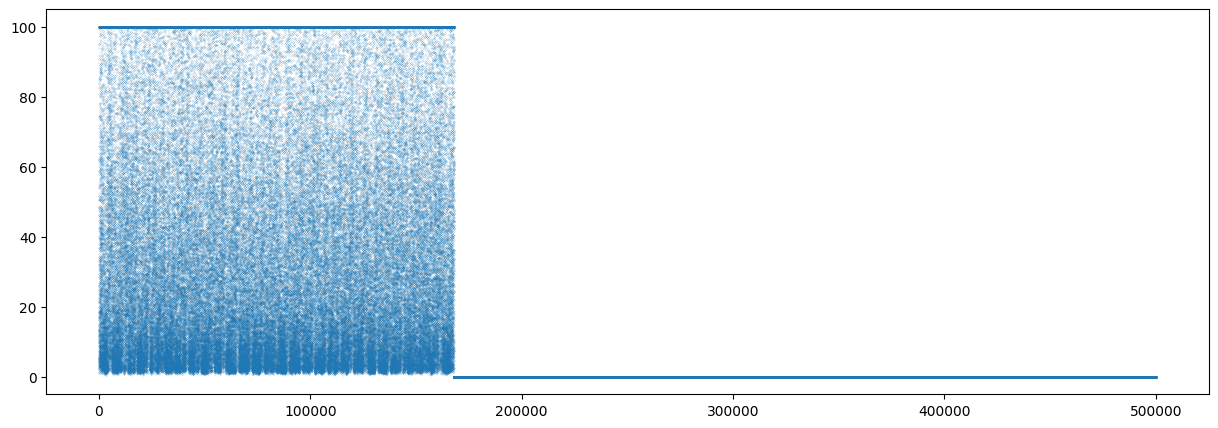

In [2]:
replay_buffer = pkl.load(open('../../data/replay_buffer_mixed.pkl', 'rb'))

plt.figure(figsize=(15, 5))
plt.plot(replay_buffer['rew'], 'o' ,markersize=0.11)

In [3]:
rb_pos_world = np.zeros((8,8,2))
kdtree_positions_world = np.zeros((64, 2))
for i in range(8):
    for j in range(8):
        if i%2!=0:
            finger_pos = np.array((i*0.0375, j*0.043301 - 0.02165))
            rb_pos_world[i,j] = np.array((i*0.0375, j*0.043301 - 0.02165))
        else:
            finger_pos = np.array((i*0.0375, j*0.043301))
            rb_pos_world[i,j] = np.array((i*0.0375, j*0.043301))
        kdtree_positions_world[i*8 + j, :] = rb_pos_world[i,j]

np.min(kdtree_positions_world, axis=0), np.max(kdtree_positions_world, axis=0)

(array([ 0.    , -0.0216]), array([0.2625, 0.3031]))

In [4]:
import numpy as np
import pickle as pkl
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch

class ImitationDataset(Dataset):
    def __init__(self, states, actions, next_states, pos, num_agents, rewards, done):
        self.states = states
        self.actions = actions
        self.next_states = next_states
        self.pos = pos
        self.num_agents = num_agents
        self.rewards = rewards
        self.done = done

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        state = self.states[idx]
        action = self.actions[idx]
        next_states = self.next_states[idx]
        pos = self.pos[idx]
        num_agents = self.num_agents[idx]
        reward = self.rewards[idx]
        done = self.done[idx]
        return state, action, next_states, pos, reward, done, num_agents

def get_smol_dataset(states, actions, next_states, pos, num_agents, rewards, done, num_samples:int=None):
    if num_samples is None:
        return ImitationDataset(states, actions, next_states, pos, num_agents, rewards, done)
        
    chosen_indices = np.random.choice(np.arange(len(states)), num_samples, replace=False)
    final_indices = np.array(chosen_indices)

    smol_states = states[final_indices]
    smol_actions = actions[final_indices]
    smol_next_states = next_states[final_indices]
    smol_pos = pos[final_indices]
    smol_num_agents = num_agents[final_indices]
    smol_rewards = rewards[final_indices]
    smol_done = done[final_indices]
    return ImitationDataset(smol_states, smol_actions, smol_next_states, smol_pos, smol_num_agents, smol_rewards, smol_done)

def split_dataset(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    # test size is the remainder

    np.random.shuffle(indices)
    
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size+val_size]
    test_indices = indices[train_size+val_size:]

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    return train_dataset, val_dataset, test_dataset

def get_dataset_and_dataloaders(
    train_bs:int=128,
    val_bs:int=128,
    test_bs:int=1,
    actor_num_samples=1000,
    critic_num_samples=10000,
    rb_path='../../data/replay_buffer_mixed.pkl'
):
    replay_buffer = pkl.load(open(rb_path, 'rb'))

    obs = replay_buffer['obs']
    act = replay_buffer['act']
    obs2 = replay_buffer['obs2']
    pos = replay_buffer['pos']
    num_agents = replay_buffer['num_agents']
    rewards = replay_buffer['rew']
    done = replay_buffer['done']

    # Actor: only actions with rewards > 30
    actor_idxs = np.where(rewards > 15)[0]
    actor_dataset = get_smol_dataset(
        obs[actor_idxs], act[actor_idxs], obs2[actor_idxs],
        pos[actor_idxs], num_agents[actor_idxs],
        rewards[actor_idxs], done[actor_idxs],
        num_samples=actor_num_samples
    )

    # Split actor dataset
    actor_train_dataset, actor_val_dataset, actor_test_dataset = split_dataset(actor_dataset)
    actor_train_loader = DataLoader(actor_train_dataset, batch_size=train_bs, shuffle=True)
    actor_val_loader = DataLoader(actor_val_dataset, batch_size=val_bs, shuffle=False)
    actor_test_loader = DataLoader(actor_test_dataset, batch_size=test_bs, shuffle=False)

    # Critic: Combine good and bad experiences into one dataset
    critic_good_idxs = np.where(rewards > 50)[0]
    critic_bad_idxs = np.where((rewards <= 50) & (rewards > -20) & (rewards != 0))[0]
    critic_all_idxs = np.concatenate([critic_good_idxs, critic_bad_idxs])

    critic_dataset = get_smol_dataset(
        obs[critic_all_idxs], act[critic_all_idxs], obs2[critic_all_idxs],
        pos[critic_all_idxs], num_agents[critic_all_idxs],
        rewards[critic_all_idxs], done[critic_all_idxs],
        num_samples=critic_num_samples
    )

    critic_train_loader = DataLoader(critic_dataset, batch_size=train_bs, shuffle=True)

    return actor_train_loader, actor_val_loader, actor_test_loader, critic_train_loader


In [5]:
num_samples = 1000
actor_train_loader, actor_val_loader, actor_test_loader, critic_train_loader = get_dataset_and_dataloaders(
    train_bs=256,
    val_bs=256,
    test_bs=1,
    actor_num_samples=num_samples,
    critic_num_samples=num_samples*5,
    rb_path='../../data/replay_buffer_mixed.pkl'
    # rb_path='../../data/replay_buffer_rope.pkl'
)


In [6]:
len(actor_train_loader), len(actor_val_loader), len(actor_test_loader)

(3, 1, 150)

In [7]:
# print(state_scaler.scaler.mean_, state_scaler.scaler.var_, action_scaler.scaler.mean_, action_scaler.scaler.var_, obj_name_encoder.classes_)

# dic = {'state_scaler': state_scaler, 'action_scaler': action_scaler, 'obj_name_encoder': obj_name_encoder}
# pkl.dump(dic, open('normalizer.pkl', 'wb'))

In [16]:
n_epochs = 1000
hp_dict = {
        "exp_name"          : "MADP_1",
        "data_dir"          : "./data/rl_data",
        'warmup_iters'      : int(n_epochs*num_samples*1e-3),
        'pi_lr'             : 1e-4,
        'pi_eta_min'        : 1e-6,
        'q_lr'              : 1e-6,
        'q_eta_min'         : 1e-8,
        'epochs'            : n_epochs,
        'ckpt_dir'          : './madp_expt_1.pth',
        'idx_embed_loc'     : './idx_embedding_new.pth',

        # DiT Params:
        'state_dim'         : 6,
        'obj_name_enc_dim'  : 9,
        'action_dim'        : 2,
        "device"            : torch.device(f"cuda:1"),
        "model_dim"         : 256,
        "num_heads"         : 8,
        "dim_ff"            : 512,
        "n_layers_dict"     : {'denoising_decoder': 10},
        "dropout"           : 0,
        "max_grad_norm"     : 2.0,

        "denoising_params"  :{
            'num_train_timesteps'   : 100,
            'beta_start'        : 0.0001,
            'beta_end'          : 0.02,
            'beta_schedule'     : 'linear',
            'variance_type'     : 'fixed_small_log',
            'clip_sample'       : True ,
            'prediction_type'   : 'epsilon',
        },

        "EMA Params":{
            'update_after_step' : 0,
            'inv_gamma'         : 1.0,
            'power'             : 0.75,
            'min_value'         : 0.5,
            'max_value'         : 0.9999,
        }
    }
# Implementation TODOs:
#   1. Add KL Divergence loss
#   2. Add normalization
#   3. Add CAWR        

model = DiffusionTransformer(hp_dict)
ema_model = deepcopy(model).to(hp_dict['device'])
model.to(hp_dict['device'])
optimizer = optim.AdamW(model.parameters(), lr=hp_dict['pi_lr'], weight_decay=1e-2)

# optimizer = optim.SGD(model.parameters(), lr=1e-2)
lr_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2, eta_min=hp_dict['pi_eta_min'])

ema = EMA(ema_model, **hp_dict['EMA Params'])

train_losses = []
val_losses = []

In [17]:
# #load state dict
# model.load_state_dict(torch.load('madp_1000_sampl_100_steps_2.pth', weights_only=True)['model'])


In [18]:
global_Step = 0
start_value = 1
end_value = 1e2
steps = hp_dict['warmup_iters']

increment = (end_value - start_value) / (steps - 1)
values = [start_value + i * increment for i in range(steps)]

for param_group in optimizer.param_groups:
    param_group['pi_lr'] = hp_dict['pi_eta_min']

for epoch in range(hp_dict['epochs']):
    with tqdm.tqdm(actor_train_loader, desc=f"Training Epoch {epoch}", leave=True, mininterval=1) as t:
        for i, (s1, a, s2, p, r, d, N) in enumerate(t):
            N = int(torch.max(N))
            
            # Noised and Denoised Variable
            actions = a[:, :N].to(hp_dict['device'])

            # Conditioning Variables
            states = s1[:, :N].to(hp_dict['device'])
            next_states = s2[:, :N].to(hp_dict['device'])
            pos = p[:, :N].to(hp_dict['device'])
            rewards = r.to(hp_dict['device'])
            dones = d.to(hp_dict['device'])
            
            optimizer.zero_grad()
            loss = model.compute_loss(actions, states, pos)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer.step()
            ema.step(model)

            if global_Step >= (steps-1):
                lr_scheduler.step()
            else:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = hp_dict['pi_eta_min'] * values[global_Step]

            train_losses.append(loss.item())
            t.set_postfix(train_loss=np.mean(train_losses[-300:]), refresh=False)
            global_Step += 1
        
        ema_model.eval()

    if epoch%20 == 0:
        model.eval()    
        with torch.no_grad():
            with tqdm.tqdm(actor_val_loader, desc=f"Validation Epoch {epoch}", leave=True, mininterval=1) as v:
                for i, (s1, a, s2, p, r, d, N) in enumerate(v):
                    N = int(torch.max(N))
                    
                    # Noised and Denoised Variable
                    actions = a[:, :N].to(hp_dict['device'])
                    states = s1[:, :N].to(hp_dict['device'])
                    next_states = s2[:, :N].to(hp_dict['device'])
                    pos = p[:, :N].to(hp_dict['device'])
                    rewards = r.to(hp_dict['device'])
                    dones = d.to(hp_dict['device'])
                    noise = torch.randn((1, N, 2), device=hp_dict['device'])

                    denoised_actions, score_data = model.actions_from_denoising_diffusion(noise, states, pos)
                    val_losses.append(F.mse_loss(actions, denoised_actions).item())

                    v.set_postfix(val_loss=np.mean(val_losses[-len(actor_val_loader):]), refresh=False)
                    if i == 50:
                        break
        model.train()

Training Epoch 999: 100%|██████████| 3/3 [00:00<00:00, 26.28it/s, train_loss=0.0159]


In [ ]:
# This block is to break the sequence of run alls
assert True==False

In [20]:
expt_dict = {"model": model.state_dict(), "ema_model": ema_model.state_dict(), "optimizer": optimizer.state_dict()}
torch.save(expt_dict, 'madp_mj.pt')

In [ ]:
madp_1000_sampl_100_steps_90_degrees_data

In [26]:
val_losses_bkp

[388148.09375,
 22139.4453125,
 286.6261291503906,
 0.6406282782554626,
 0.0012031755177304149,
 0.0009329577442258596,
 0.0007318007992580533,
 0.0006702234386466444,
 0.0006614646408706903,
 0.0005448139272630215,
 0.00043730027391575277,
 0.0003457198617979884,
 0.0003699736553244293,
 0.0002659778983797878,
 0.0002508978359401226,
 0.00021258517517708242,
 0.0002488548925612122,
 0.00026139337569475174,
 0.00019556192273739725,
 0.0002186835918109864,
 0.00020421492808964103,
 0.00014172187366057187,
 0.00021613827266264707,
 0.00027607433730736375,
 0.00020621062139980495,
 0.00015042182349134237,
 0.000134556190459989,
 0.00015128769155126065,
 0.0001823565544327721,
 0.0002288853720529005,
 0.00015287754649762064,
 0.00013995975314173847,
 0.00010218889656243846,
 0.00014088406169321388,
 9.786336886463687e-05,
 8.094360964605585e-05,
 8.612219244241714e-05,
 8.318264008266851e-05,
 0.0001384117203997448,
 0.00013185065472498536,
 0.00013710960047319531,
 0.00014590664068236947,

In [19]:
train_losses_bkp = train_losses
val_losses_bkp = val_losses

In [27]:
train_losses = train_losses_bkp
val_losses = val_losses_bkp

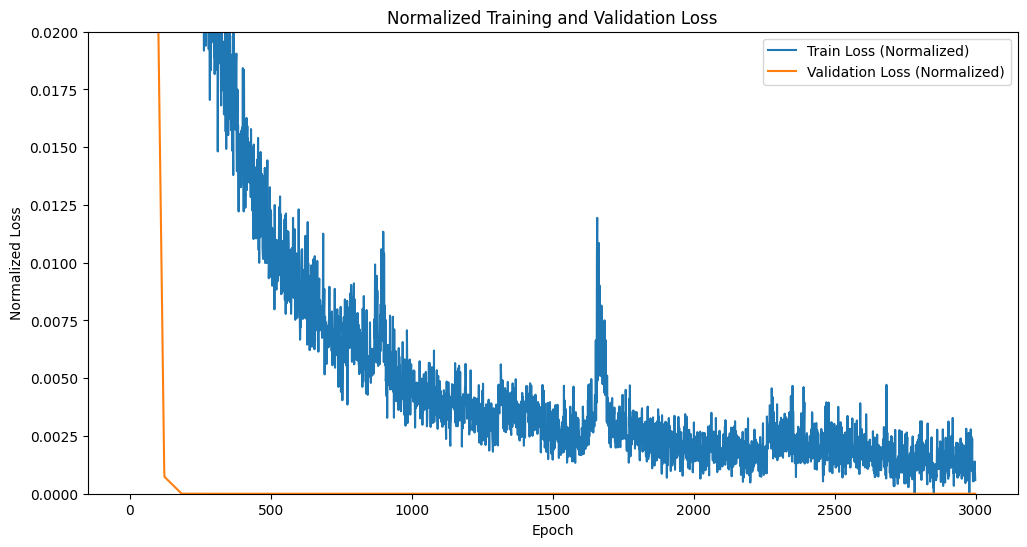

In [30]:
train_losses = np.array(train_losses_bkp)
val_losses = np.array(val_losses_bkp)
x_val = np.linspace(0, len(train_losses) - 1, len(val_losses))
x_train = np.arange(len(train_losses))
val_losses_interpolated = np.interp(x_train, x_val, val_losses)

# Step 2: Normalization of both losses
scaler = MinMaxScaler()


# combined_losses = np.concatenate((loss_train, loss_val_interpolated)).reshape(-1, 1)
# scaler.fit(combined_losses)

# Reshape for sklearn which expects 2D array
train_losses_normalized = scaler.fit_transform(train_losses.reshape(-1, 1)).flatten()
val_losses_normalized = scaler.fit_transform(val_losses_interpolated.reshape(-1, 1)).flatten()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_losses_normalized, label='Train Loss (Normalized)')
plt.plot(val_losses_normalized, label='Validation Loss (Normalized)')
plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')
plt.title('Normalized Training and Validation Loss')
plt.ylim(0, 0.02)
plt.legend()
plt.show()

In [25]:
import time
def actions_from_denoising_diffusion(model, x_T, states, obj_name_encs, pos, gamma=None):
    # actions get denoised from x_T --> x_t --> x_0
    actions = x_T
    shape = actions.shape
    score_data = []
    with torch.no_grad():
        for i in reversed(range(model.denoising_params['num_train_timesteps'])):
            t = torch.tensor([i]*shape[0], device=model.device)
            ### p_mean_variance
            pred_noise = model.denoising_decoder(actions, states, obj_name_encs, pos)
            score_data.append(pred_noise.detach().cpu().numpy())

            model_variance = _extract_into_tensor(model.posterior_variance, t, shape)
            model_log_variance = _extract_into_tensor(model.posterior_log_variance_clipped, t, shape)

            pred_x_start = _extract_into_tensor(model.sqrt_recip_alphas_cumprod, t, shape) * actions\
                        - _extract_into_tensor(model.sqrt_recipm1_alphas_cumprod, t, shape) * pred_noise
            
            model_mean = _extract_into_tensor(model.posterior_mean_coef1, t, shape) * pred_x_start\
                        + _extract_into_tensor(model.posterior_mean_coef2, t, shape) * actions
            
            ### p_sample
            noise = torch.randn(shape, device=model.device)
            nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(shape) - 1))))
            actions = model_mean + nonzero_mask * model_variance * noise
    return actions, np.array(score_data)

In [26]:
# num_samples = 5000
# train_loader2, val_loader2, test_loader2, state_scaler2, action_scaler2, obj_name_encoder2 = get_dataset_and_dataloaders(train_bs=256, test_bs=128, num_samples=num_samples, obj_of_interest=None)

In [33]:
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.graph_objects as go


model.eval()
loss = []
statesss = []
actionsss = []
actions_gt = []
possss = []

grand_data = np.zeros((100, 128, 10, 2))
with torch.no_grad():
    with tqdm.tqdm(actor_test_loader, desc=f"Validation Epoch {epoch}", leave=False, mininterval=1) as v:
        for i, (s1, a, s2, p, r, d, N) in enumerate(v):
            N = int(torch.max(N))
            
            # Noised and Denoised Variable
            actions = a[:, :N].to(hp_dict['device'])
            states = s1[:, :N].to(hp_dict['device'])
            next_states = s2[:, :N].to(hp_dict['device'])
            pos = p[:, :N].to(hp_dict['device'])
            rewards = r.to(hp_dict['device'])
            dones = d.to(hp_dict['device'])
            noise = torch.randn((1, N, 2), device=hp_dict['device'])
            actions_gt.append(actions)
            statesss.append(states)
            possss.append(pos)

            now = time.time()
            denoised_actions, score_data = model.actions_from_denoising_diffusion(noise, states, pos)
            print(time.time() - now)
            # print(states, pos, obj_name_encs, denoised_actions)
            actionsss.append(denoised_actions)
            loss.append(F.mse_loss(actions, denoised_actions).item())

            if i==30:
                break

        # for i, (states, actions, obj_name_encs, pos, num_agents, rewards) in enumerate(v):
        #     # Print torch dtypes of all

        #     n_agents = int(torch.max(num_agents))
        #     # print(n_agents)
            
        #     # Noised and Denoised Variable
        #     actions = actions[:, :n_agents].to(hp_dict['device'])

        #     # Conditioning Variables
        #     states = states[:, :n_agents].to(hp_dict['device'])
        #     obj_name_encs = obj_name_encs.long().to(hp_dict['device'])
        #     pos = pos[:, :n_agents].to(hp_dict['device'])

        #     noise = torch.randn((1, n_agents, 2), device=hp_dict['device'])
        #     denoised_actions, score_data = actions_from_denoising_diffusion(model, noise, states, obj_name_encs, pos)
# denoising_steps, batchsize, N, _ = score_data.shape
# denoising_steps_range = np.arange(denoising_steps)
# agents_range = np.arange(N)
# denoising_steps_mesh, agents_mesh = np.meshgrid(denoising_steps_range, agents_range)

# # Compute the mean over the batch dimension for X and Y coordinates
# mean_x = score_data[:, :, :, 0].mean(axis=1)
# mean_y = score_data[:, :, :, 1].mean(axis=1)

# # Create the 3D surface plot
# fig = go.Figure(data=[go.Surface(x=denoising_steps_mesh, y=agents_mesh, z=mean_x)])

# # Update the layout
# fig.update_layout(
#     scene=dict(
#         xaxis=dict(title='Denoising Step'),
#         yaxis=dict(title='Agent'),
#         zaxis=dict(title='X Coordinate')
#     ),
#     title='Score Function Surface Plot'
# )

# # Add the second surface for Y coordinates
# fig.add_trace(go.Surface(x=denoising_steps_mesh, y=agents_mesh, z=mean_y,
#                          colorscale='Viridis', opacity=0.7, showscale=False))

# fig.write_html('score_function_plot.html')
# fig.show()

Validation Epoch 999:   0%|          | 0/150 [00:00<?, ?it/s]

0.4052248001098633
0.4059758186340332


Validation Epoch 999:   2%|▏         | 3/150 [00:01<01:01,  2.41it/s]

0.4183835983276367
0.40427541732788086
0.40610694885253906


Validation Epoch 999:   4%|▍         | 6/150 [00:02<00:59,  2.44it/s]

0.40541887283325195
0.39627575874328613
0.39165472984313965


Validation Epoch 999:   6%|▌         | 9/150 [00:03<00:57,  2.47it/s]

0.4012150764465332
0.38890767097473145
0.39113426208496094


Validation Epoch 999:   8%|▊         | 12/150 [00:04<00:55,  2.50it/s]

0.3915445804595947
0.39733242988586426
0.3972620964050293


Validation Epoch 999:  10%|█         | 15/150 [00:06<00:53,  2.51it/s]

0.39234113693237305
0.3921976089477539
0.39600157737731934


Validation Epoch 999:  12%|█▏        | 18/150 [00:07<00:52,  2.51it/s]

0.3986783027648926
0.4017479419708252
0.3991849422454834


Validation Epoch 999:  14%|█▍        | 21/150 [00:08<00:51,  2.51it/s]

0.39499855041503906
0.4008457660675049
0.4039125442504883


Validation Epoch 999:  16%|█▌        | 24/150 [00:09<00:50,  2.50it/s]

0.40229177474975586
0.403439998626709
0.40298986434936523


Validation Epoch 999:  18%|█▊        | 27/150 [00:10<00:49,  2.49it/s]

0.40147852897644043
0.3981289863586426
0.3984415531158447


Validation Epoch 999:  20%|██        | 30/150 [00:12<00:48,  2.50it/s]

0.39374828338623047


0.3904910087585449


0.00015157520166183297

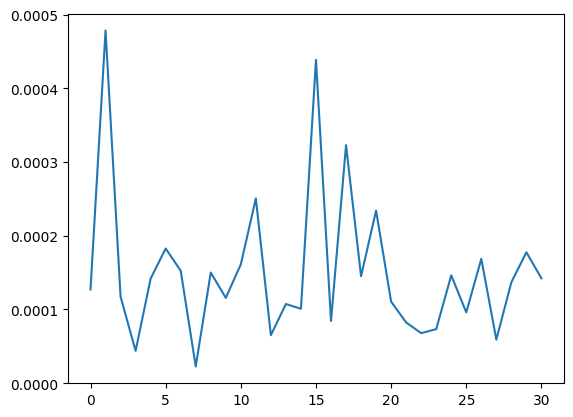

In [34]:
plt.plot(loss)
np.mean(loss)

In [35]:
statesss[0].detach().cpu().numpy().shape, len(statesss)

((1, 9, 6), 31)

[[ 0.0284  0.0314]
 [ 0.0026 -0.0167]
 [-0.0184  0.0426]
 [-0.0041  0.0054]
 [-0.0368  0.0328]
 [-0.0032 -0.0163]
 [-0.0462  0.0074]
 [-0.0096 -0.0161]
 [-0.0647  0.0363]]


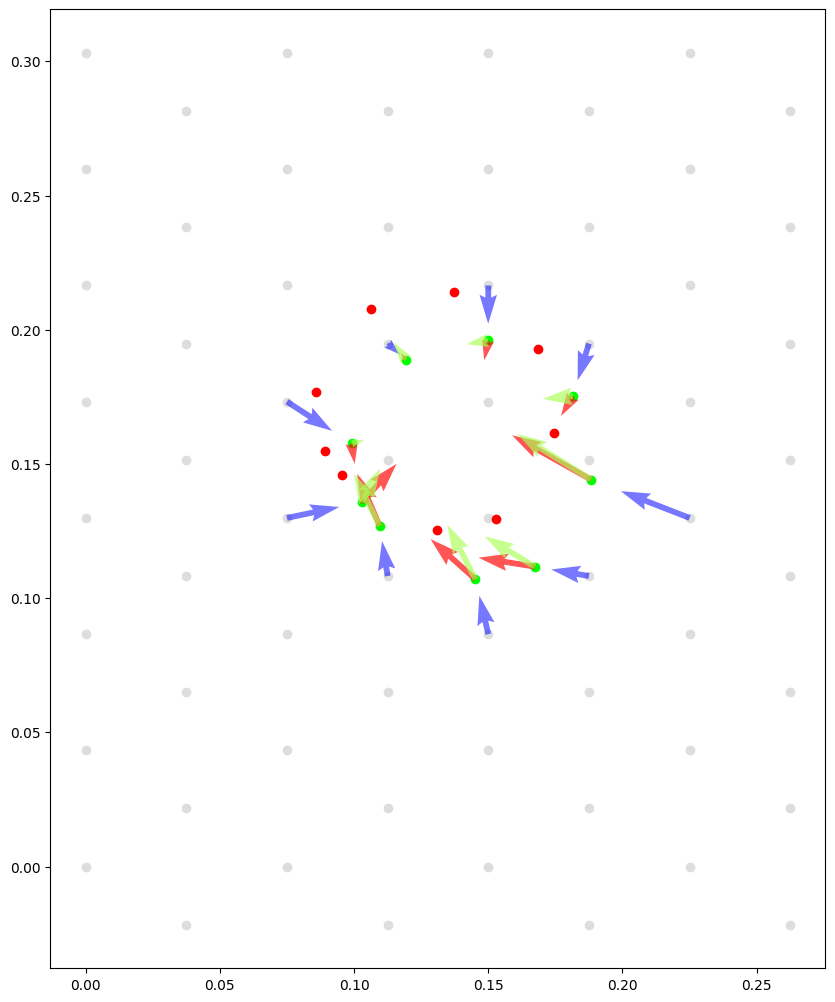

[[-0.0016  0.0316]
 [ 0.0392 -0.0051]
 [ 0.0163  0.0408]
 [-0.0241  0.0045]
 [-0.025   0.0249]
 [-0.0193  0.0037]]


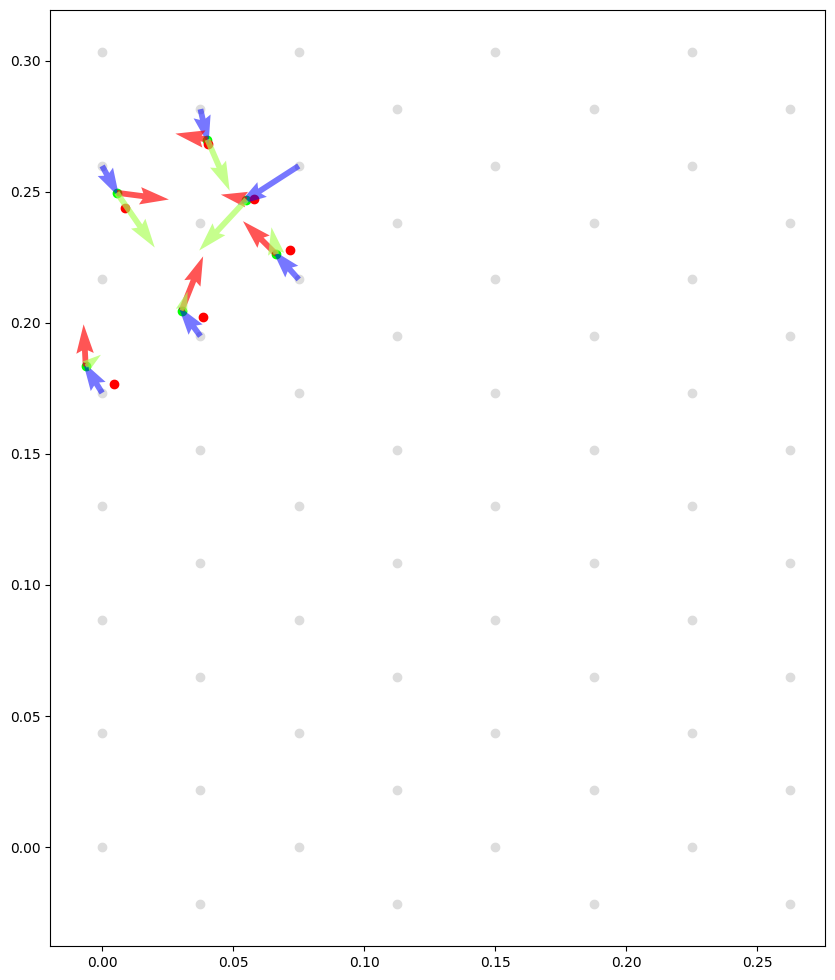

[[ 0.024   0.0193]
 [ 0.0133  0.0035]
 [ 0.0317 -0.0061]
 [-0.0115  0.0065]
 [-0.0028  0.0476]
 [ 0.0007 -0.0042]
 [-0.0385  0.0594]
 [-0.0201  0.0024]
 [-0.013   0.005 ]]


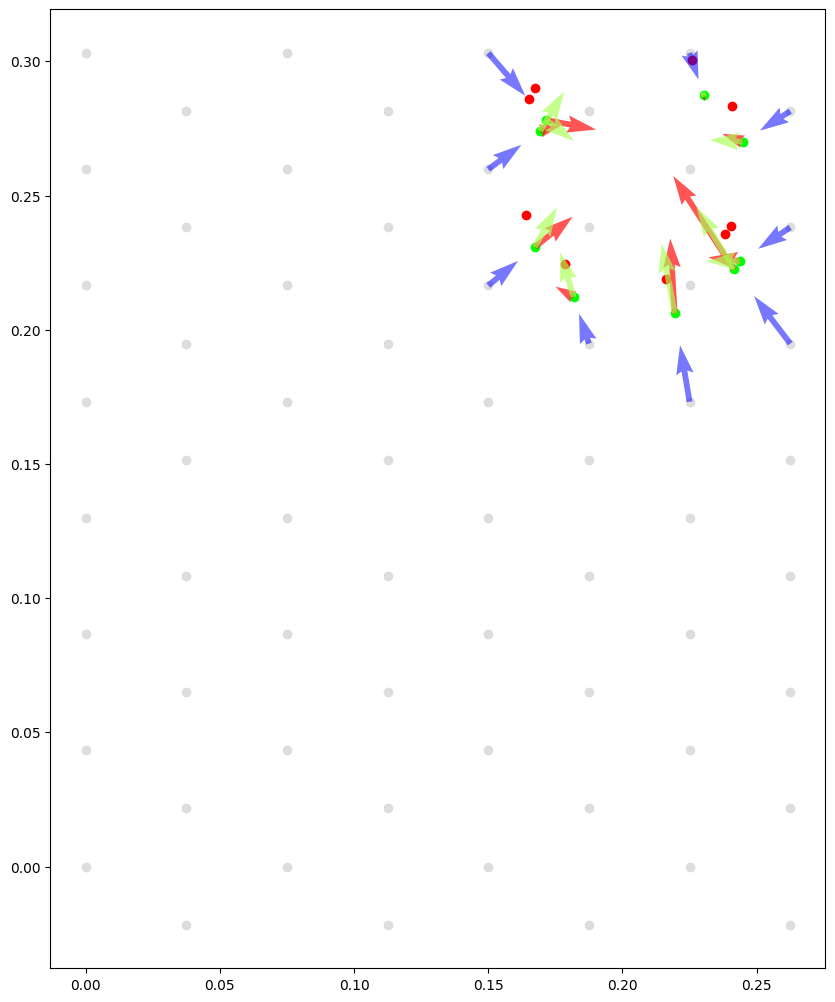

[[ 0.0032  0.0273]
 [ 0.0139  0.0087]
 [ 0.0108  0.0088]
 [-0.0147  0.0373]
 [-0.0096 -0.0241]
 [-0.0141  0.0273]
 [-0.0072  0.0065]
 [-0.0525  0.028 ]]


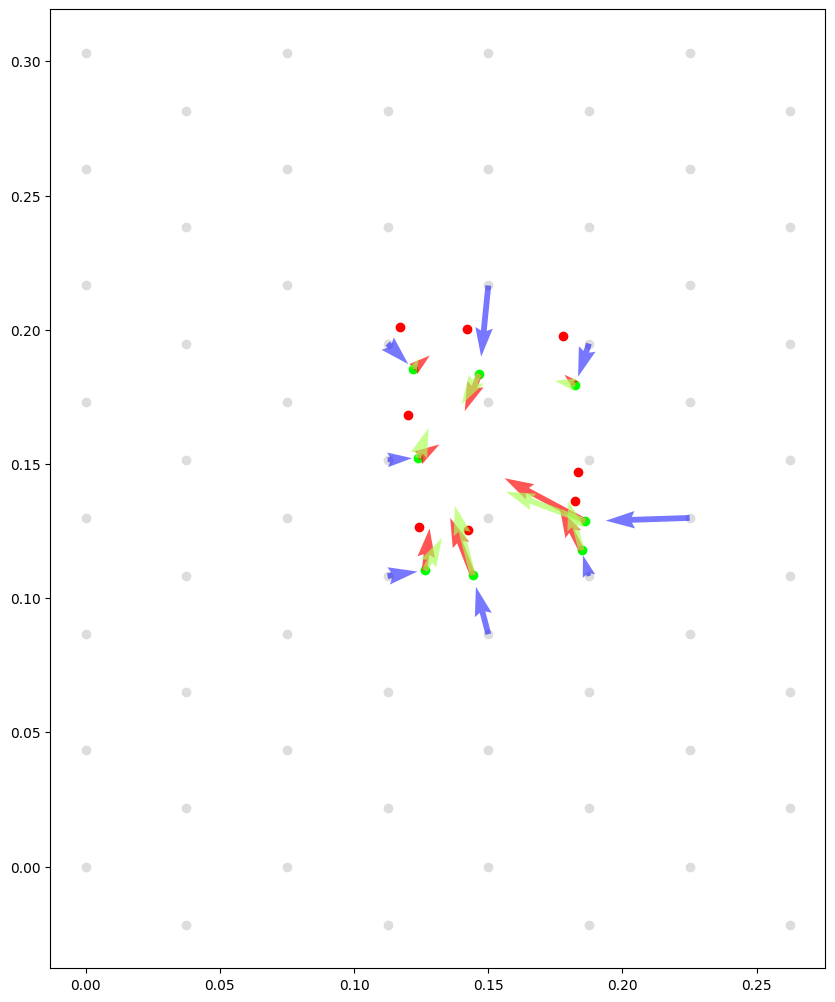

[[ 0.0043 -0.0022]
 [-0.0139 -0.0366]
 [ 0.0015 -0.0362]
 [ 0.0022  0.0158]
 [-0.0072  0.0148]
 [-0.0347 -0.0265]
 [-0.0666  0.0086]
 [-0.0383  0.0024]]


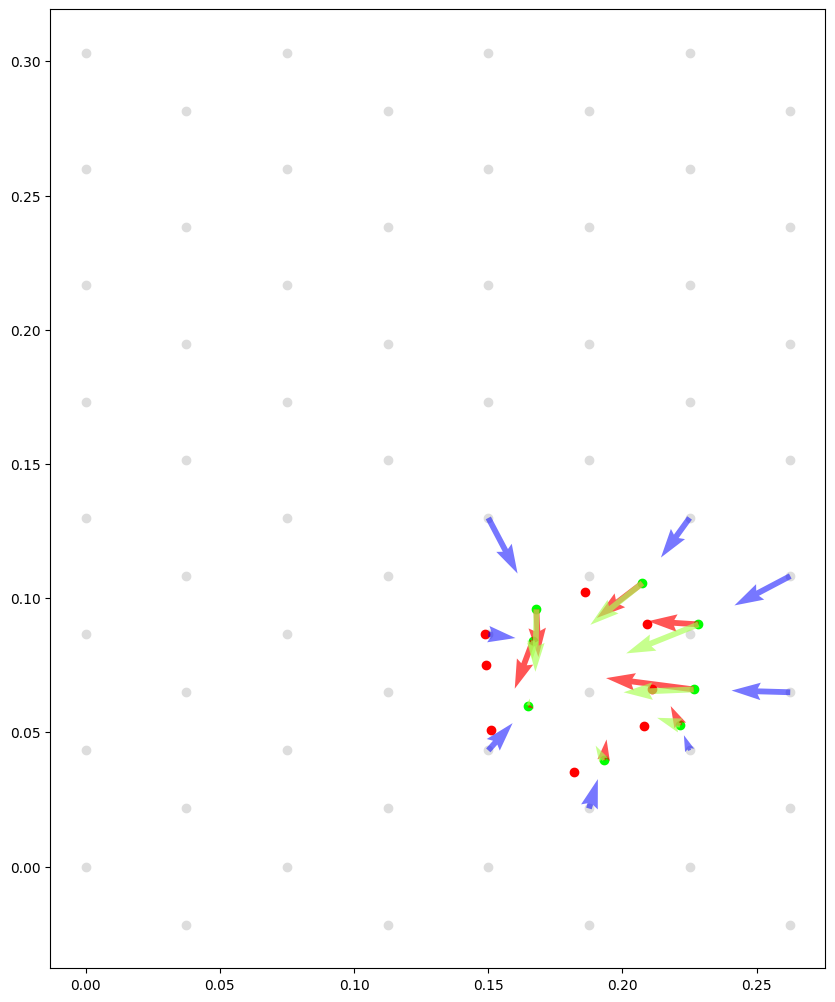

[[ 0.0126  0.0319]
 [ 0.0264 -0.0083]
 [ 0.0204 -0.0524]
 [ 0.012   0.0387]
 [ 0.0156 -0.0257]
 [-0.0249  0.0304]
 [-0.0366 -0.0089]
 [-0.0515  0.0166]
 [-0.0577 -0.01  ]]


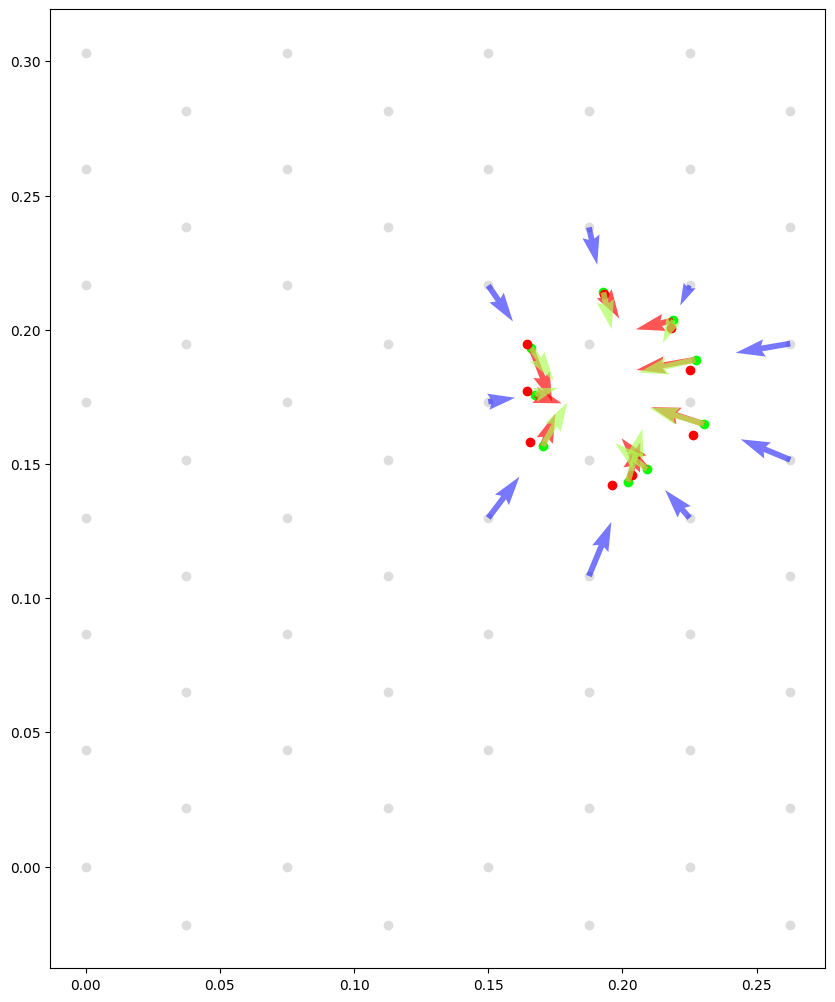

[[ 0.0206  0.0208]
 [-0.0007 -0.0007]
 [ 0.0068 -0.0098]
 [ 0.0029  0.0428]
 [-0.0453 -0.0262]
 [-0.0187  0.0312]]


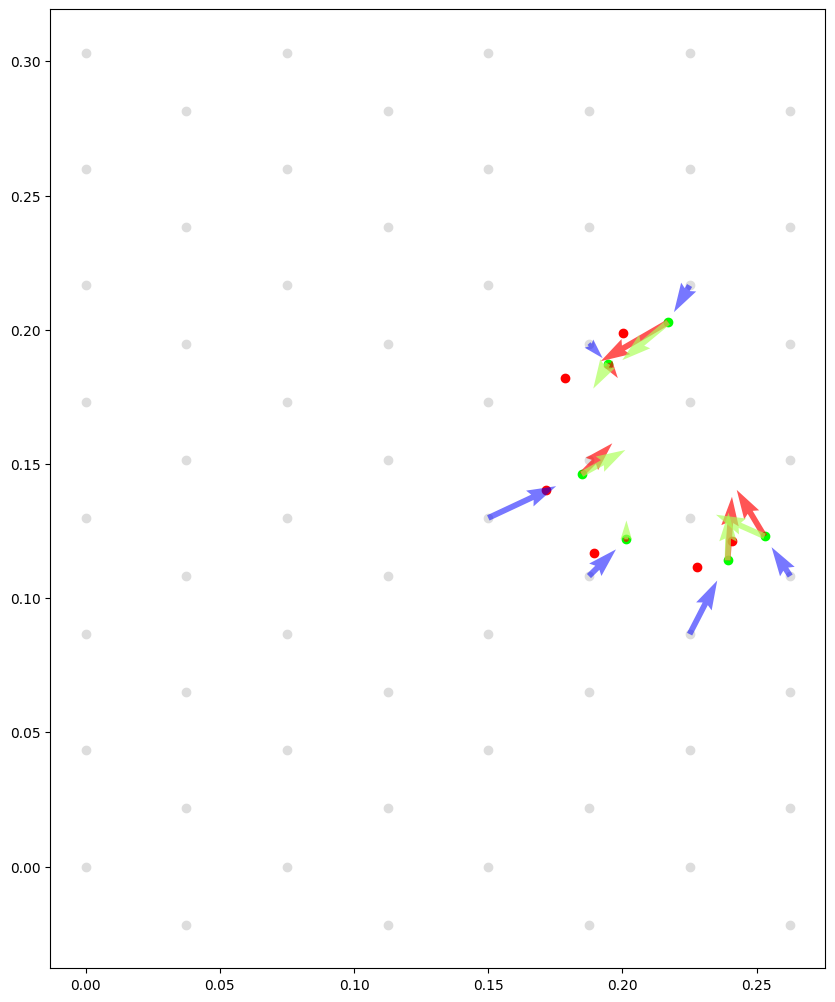

[[-0.0036  0.0358]
 [-0.0025  0.0051]
 [ 0.0171 -0.0025]
 [ 0.0226 -0.0052]
 [-0.0016  0.0348]
 [-0.0064 -0.0209]
 [-0.0285  0.0178]
 [-0.0231 -0.0015]
 [-0.0071 -0.006 ]
 [-0.0474  0.0204]
 [-0.0343  0.0065]]


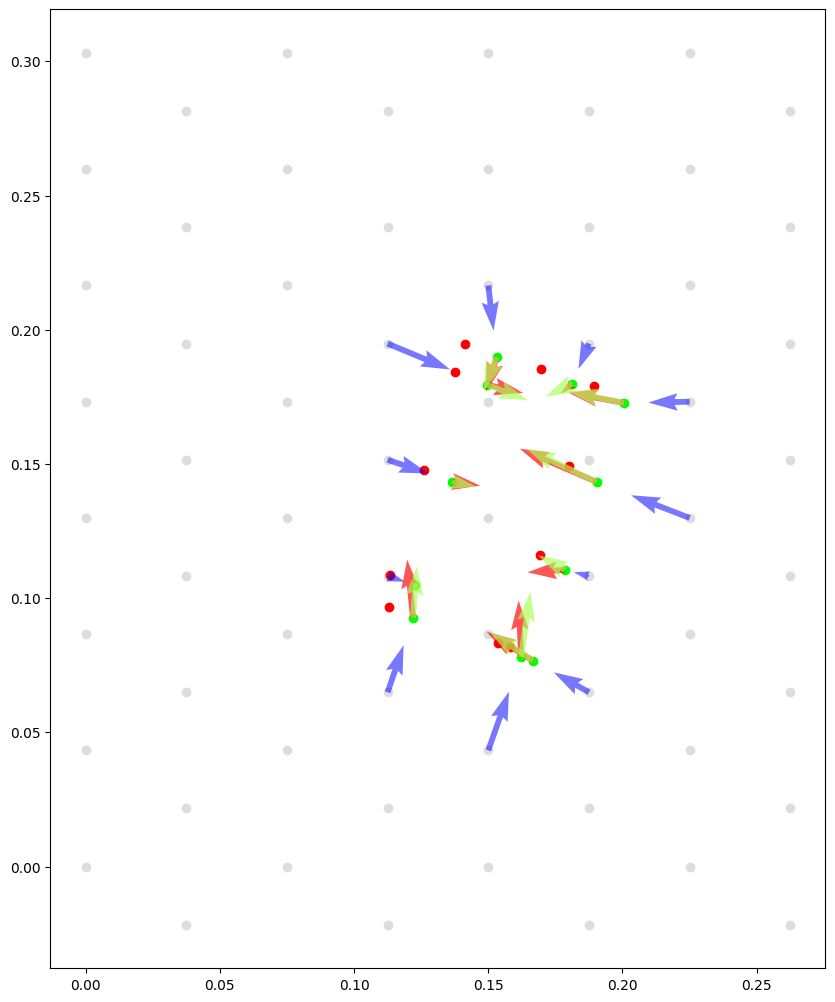

[[ 0.0095 -0.0127]
 [ 0.0041  0.0133]
 [-0.0095 -0.0021]
 [ 0.0243  0.051 ]
 [-0.0399  0.0262]
 [-0.0208  0.0221]
 [-0.0372 -0.006 ]]


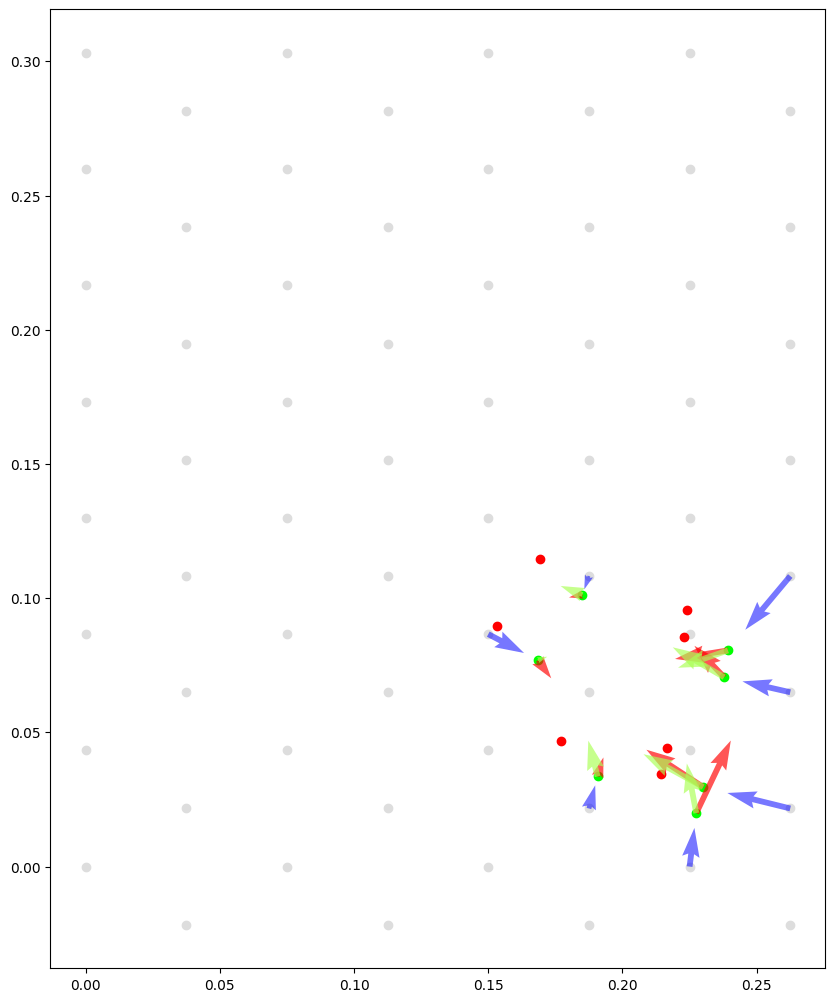

[[ 0.0239  0.0307]
 [ 0.0309  0.0021]
 [-0.0052  0.0275]
 [-0.0275  0.007 ]
 [-0.0084 -0.0178]]


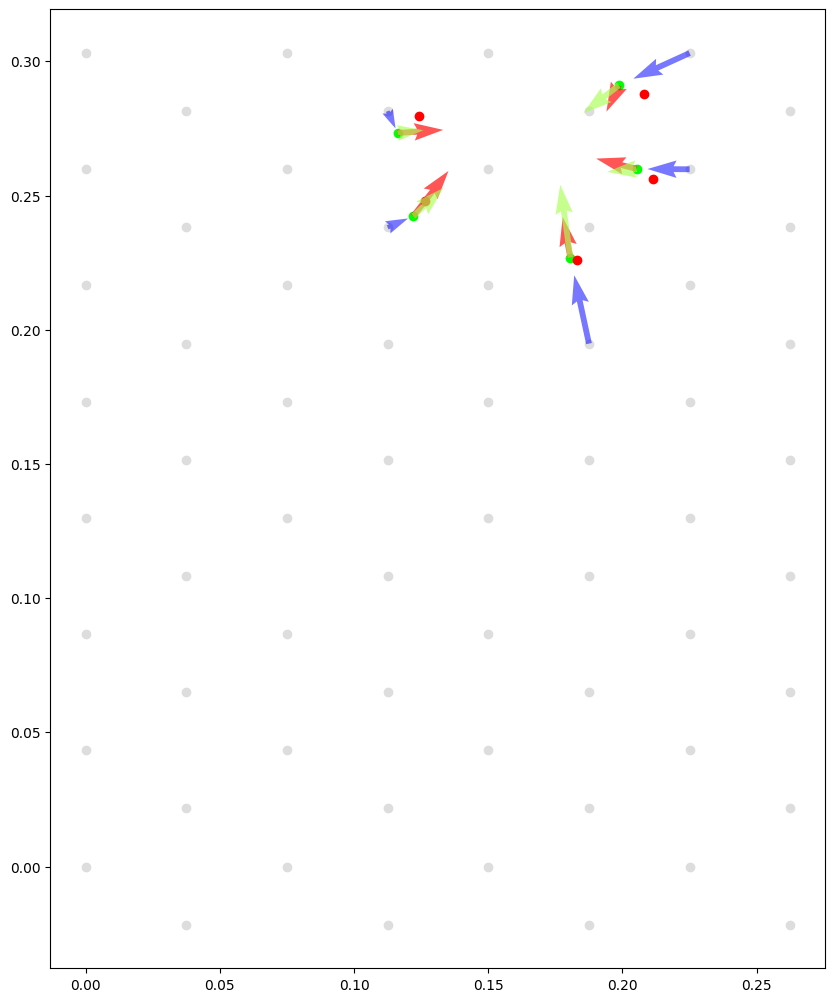

[[ 0.0244 -0.034 ]
 [-0.0122  0.0182]
 [-0.0098 -0.0186]
 [-0.0467  0.0157]
 [-0.0145 -0.0249]]


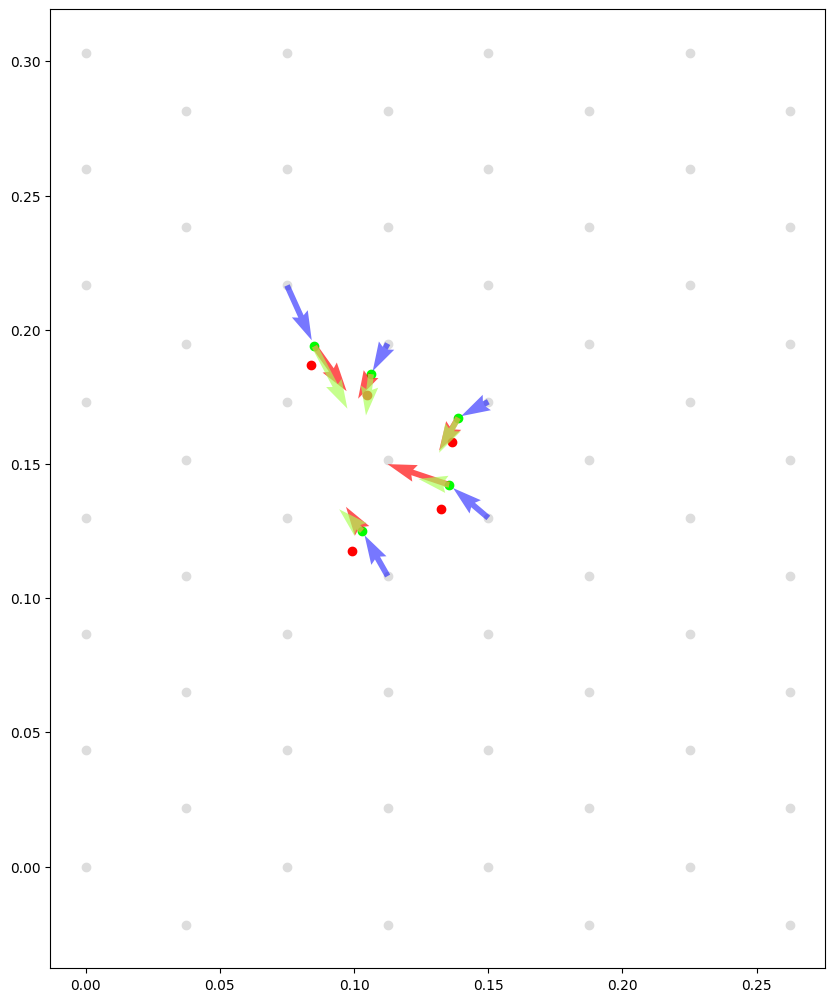

[[ 0.0224  0.0171]
 [ 0.0623 -0.042 ]
 [ 0.0048 -0.006 ]
 [-0.0184  0.0378]
 [-0.0116  0.0382]
 [-0.0289  0.0175]]


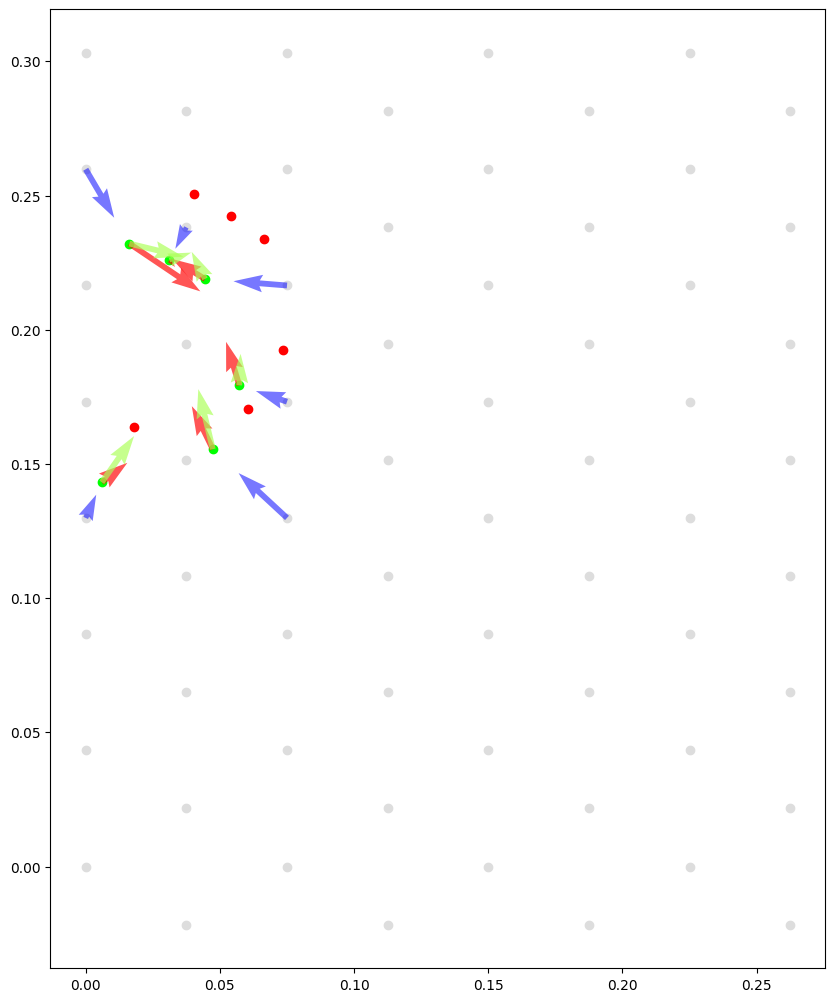

[[ 0.0337  0.0104]
 [ 0.0163  0.0182]
 [ 0.0168 -0.0024]
 [-0.0276  0.0465]
 [ 0.0193 -0.0108]
 [-0.0054  0.0306]
 [ 0.0138 -0.0185]
 [-0.0072  0.0203]
 [-0.0059  0.003 ]
 [-0.0186 -0.0142]]


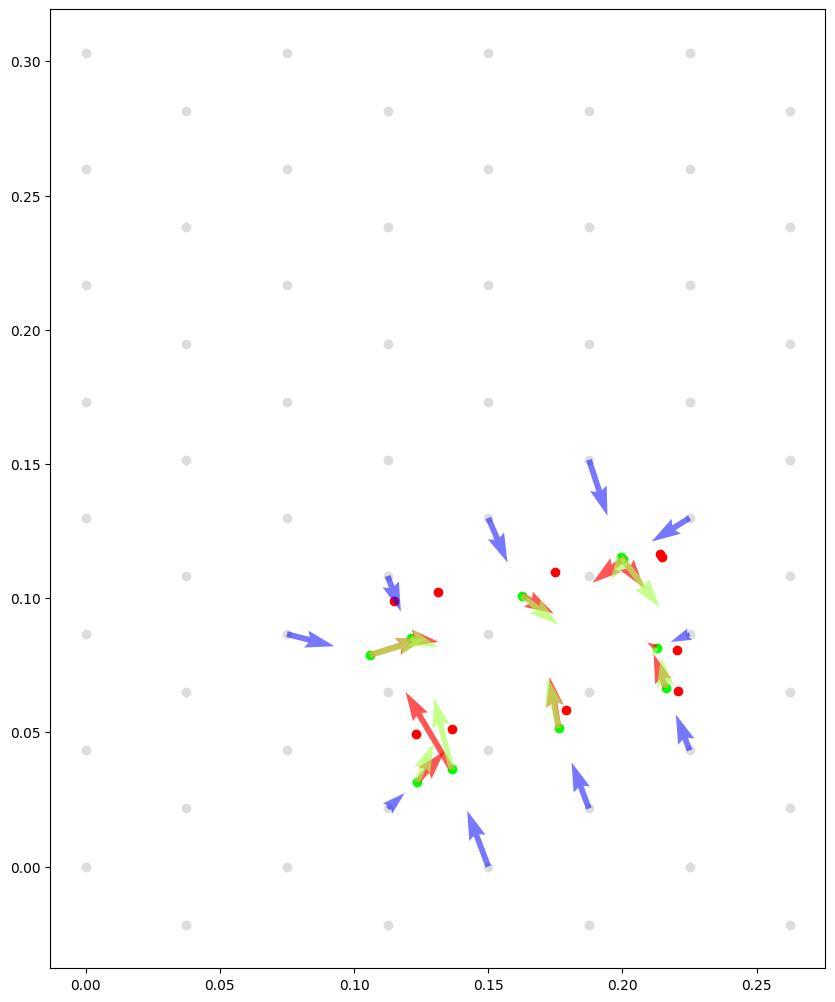

[[ 0.0554 -0.0098]
 [ 0.0083 -0.0374]
 [ 0.0427  0.0203]
 [ 0.0158 -0.0309]
 [ 0.0089 -0.0175]
 [-0.0087  0.013 ]
 [-0.0051 -0.0124]]


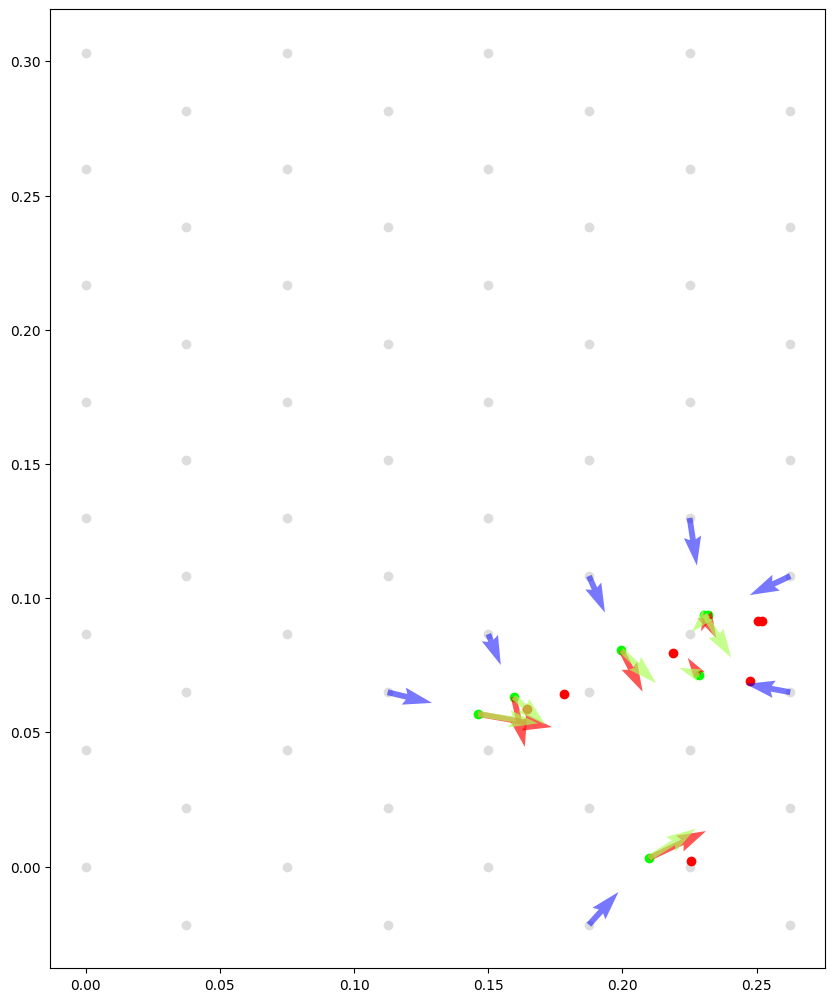

[[ 0.0152  0.031 ]
 [-0.0102  0.0092]
 [ 0.0037  0.0197]
 [ 0.0043  0.0101]
 [-0.0227  0.0394]
 [ 0.0007 -0.0058]
 [-0.0409  0.0128]
 [-0.0291  0.0121]
 [-0.0456 -0.0032]]


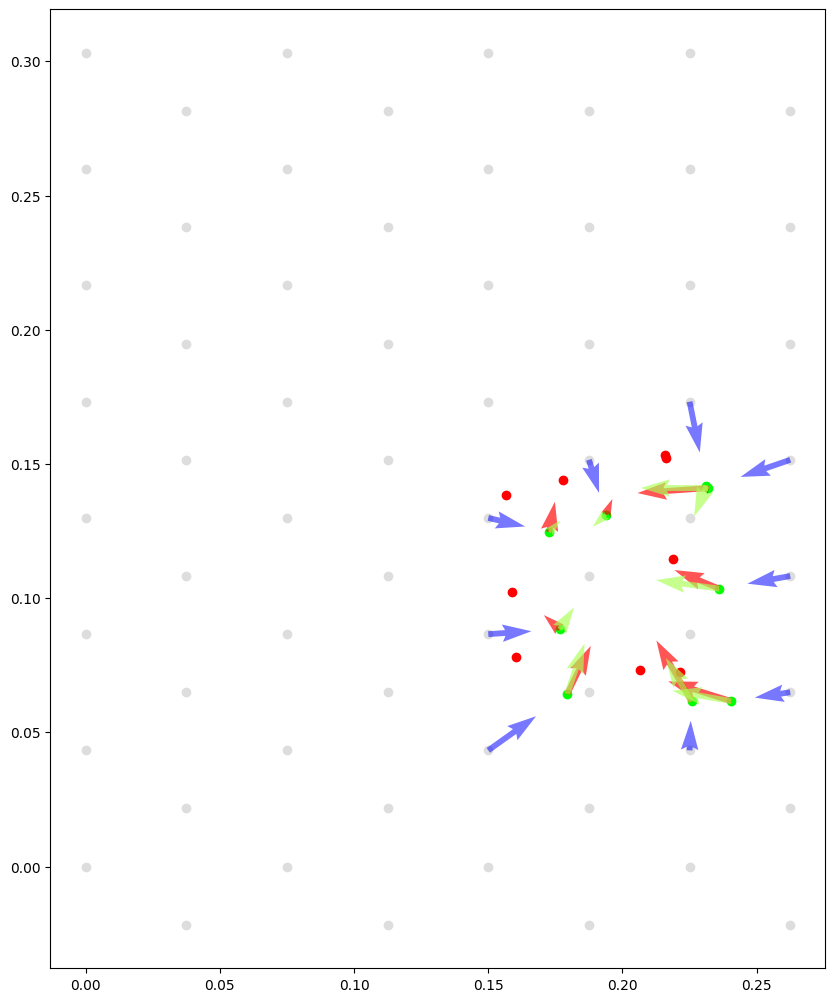

[[ 0.0609 -0.0207]
 [ 0.036  -0.0417]
 [ 0.028   0.0225]
 [-0.008  -0.0199]
 [-0.026   0.0355]
 [ 0.0178 -0.0569]
 [-0.0368  0.037 ]
 [ 0.0009 -0.0208]]


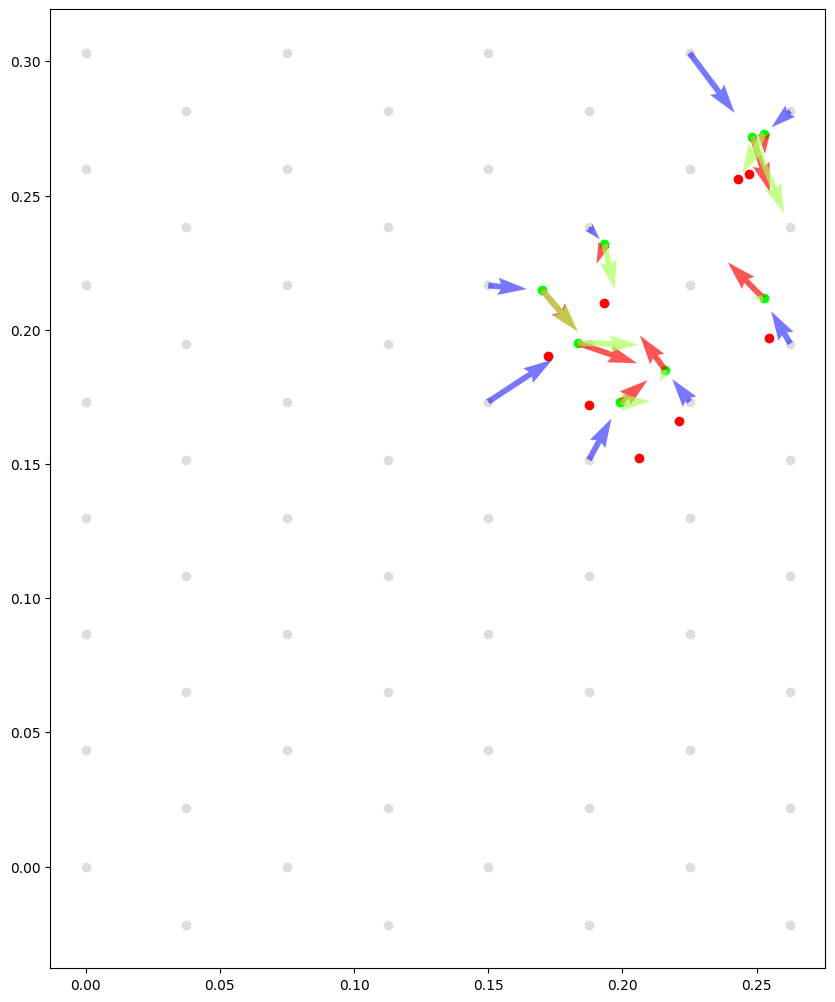

[[ 0.0204  0.0112]
 [ 0.0171 -0.0046]
 [ 0.017  -0.0219]
 [-0.004   0.0313]
 [-0.0117 -0.0318]
 [-0.0215  0.0097]
 [-0.0107 -0.0199]
 [-0.0438  0.0091]]


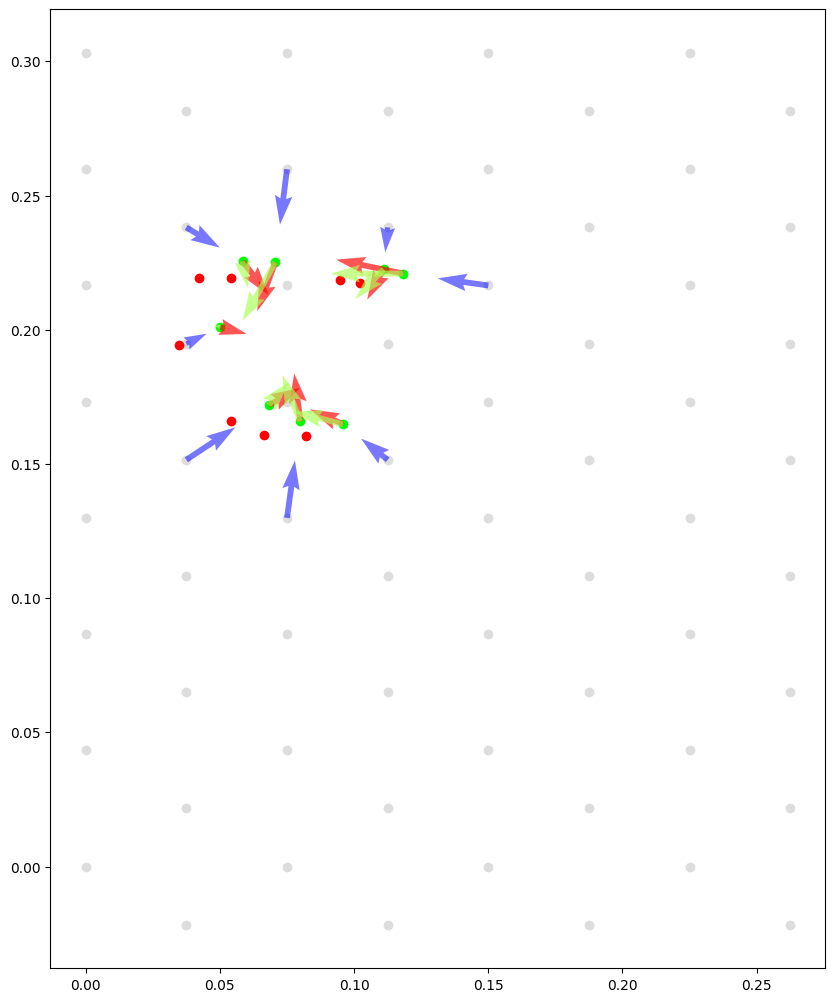

[[ 0.018  -0.0054]
 [-0.0022 -0.0476]
 [ 0.0086 -0.0316]
 [ 0.0118  0.0046]
 [-0.0322 -0.0232]
 [-0.0198  0.0044]
 [-0.0117 -0.0303]
 [-0.0024 -0.0251]]


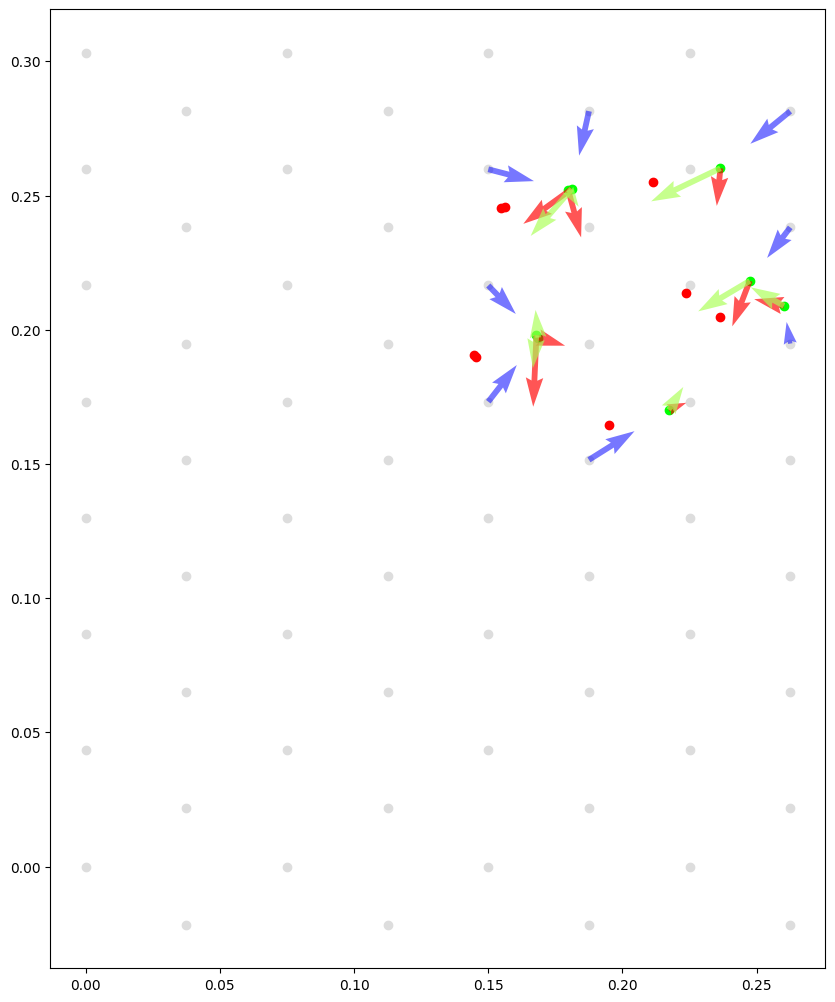

[[ 0.0235  0.0138]
 [ 0.0479  0.0107]
 [ 0.0038  0.0132]
 [ 0.0113 -0.0226]
 [ 0.0177  0.0417]
 [ 0.0073 -0.0047]
 [-0.0094  0.0532]
 [-0.0263  0.0022]
 [-0.0359  0.0489]
 [-0.0317  0.012 ]]


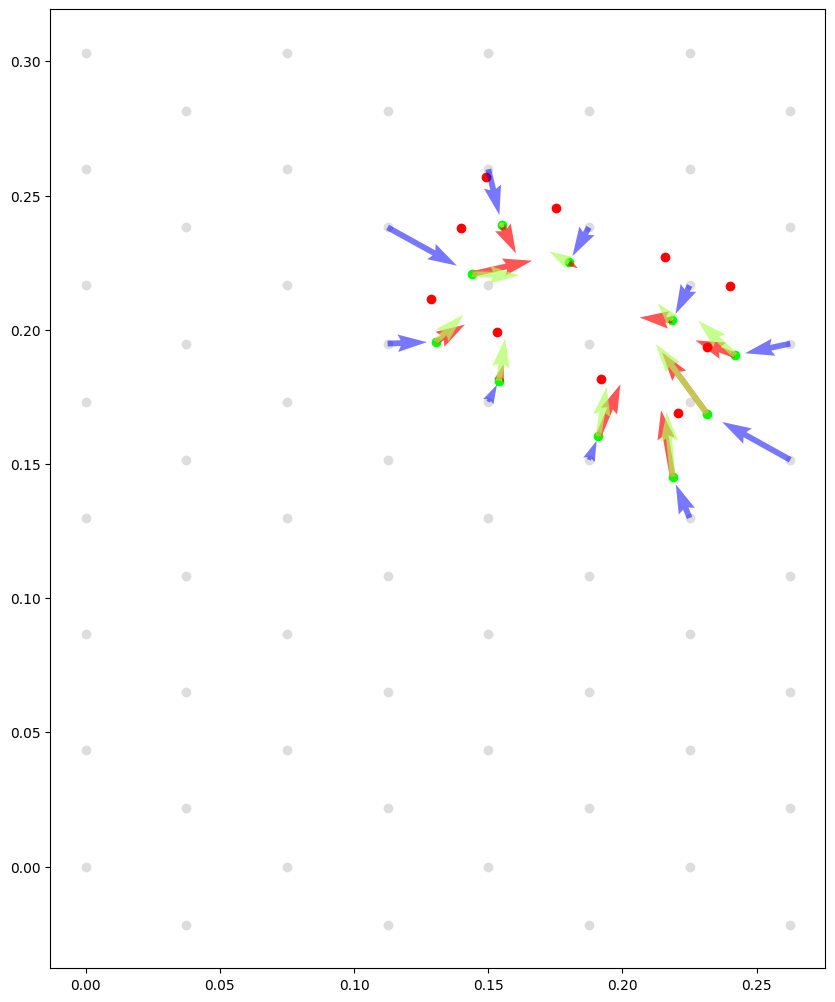

[[ 0.048  -0.0119]
 [ 0.0227  0.0058]
 [ 0.0147 -0.0064]
 [ 0.0171  0.0206]
 [ 0.0028 -0.0021]
 [-0.003   0.025 ]
 [-0.0128 -0.0454]
 [-0.0358  0.0166]
 [-0.0106 -0.0141]
 [-0.0085 -0.0135]]


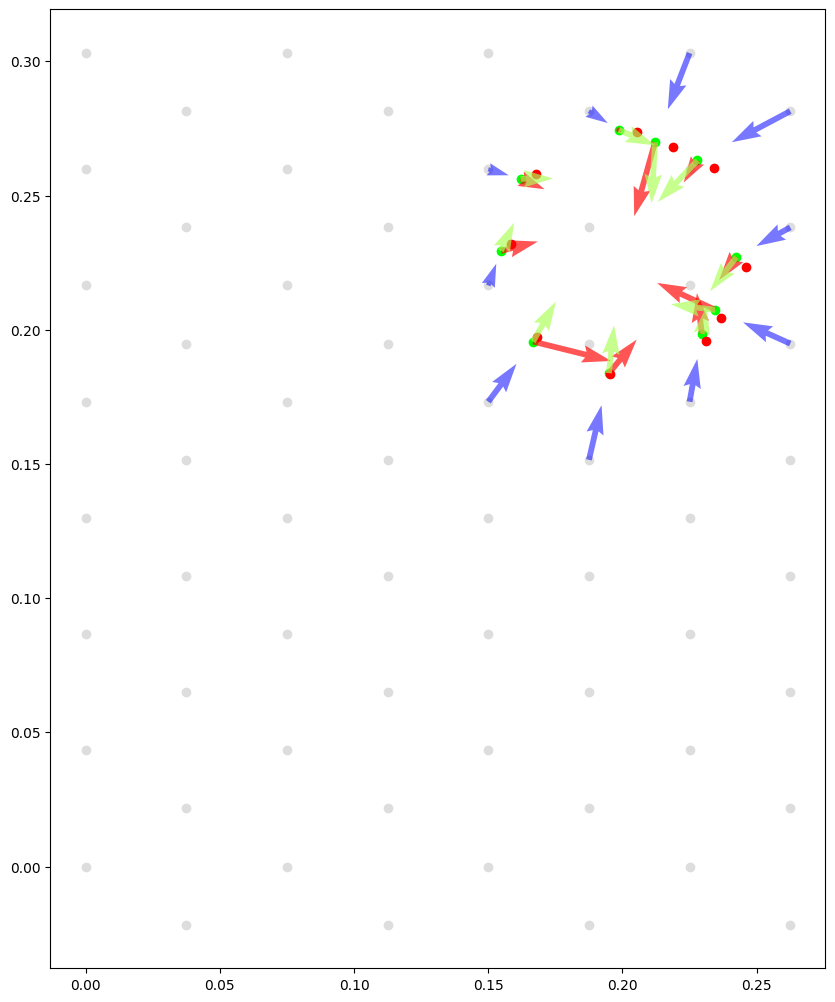

[[ 0.021   0.0251]
 [ 0.0373  0.0051]
 [ 0.0099  0.0482]
 [ 0.0096 -0.0026]
 [ 0.0368 -0.0177]
 [ 0.0131  0.0366]
 [ 0.004  -0.0289]
 [-0.0101  0.0195]
 [-0.0101 -0.0021]
 [-0.0306 -0.0095]]


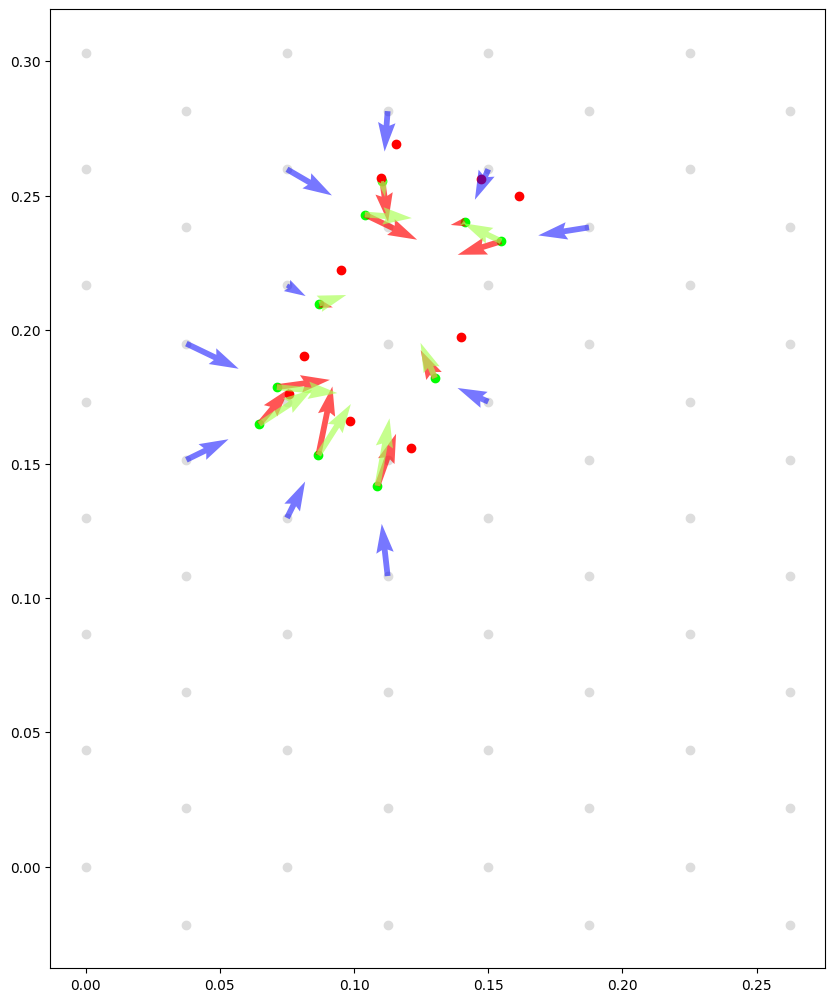

[[ 0.039   0.023 ]
 [ 0.0266  0.0111]
 [ 0.0308  0.006 ]
 [ 0.008   0.0378]
 [ 0.004   0.0192]
 [ 0.0042  0.0071]
 [-0.043   0.0066]]


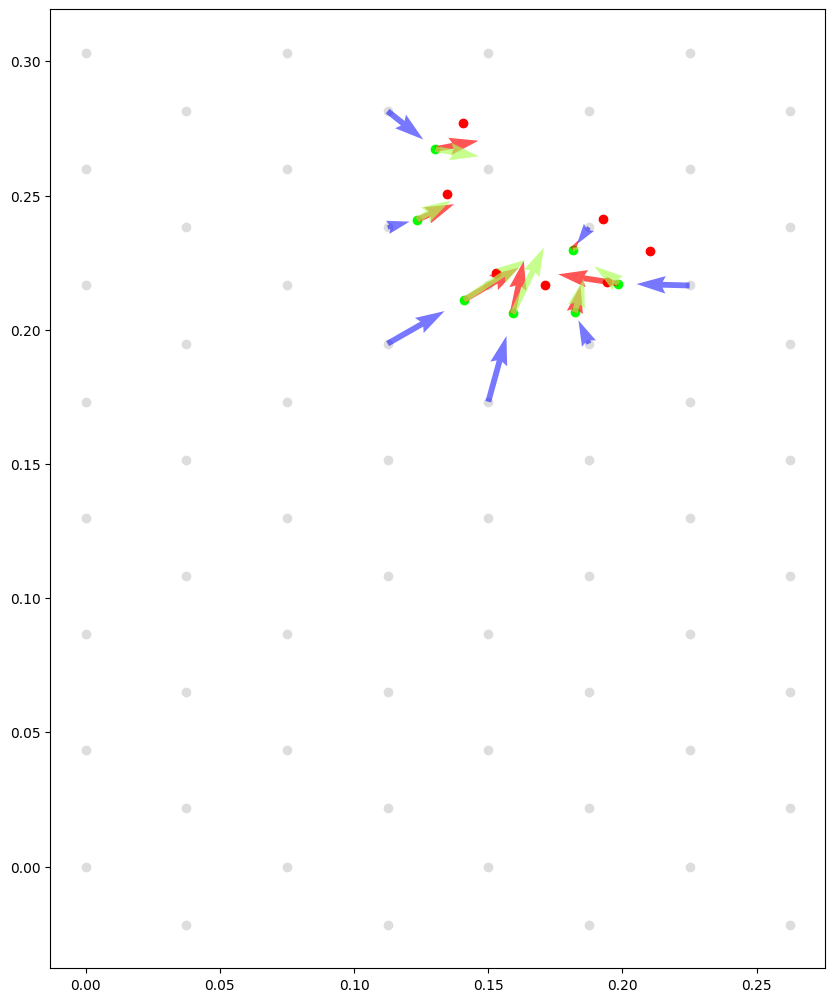

[[ 0.0004  0.0245]
 [ 0.0006 -0.018 ]
 [ 0.016   0.0041]
 [ 0.0254 -0.0428]
 [-0.0133  0.008 ]
 [-0.0148 -0.03  ]
 [-0.0141  0.0225]
 [-0.0222 -0.0163]]


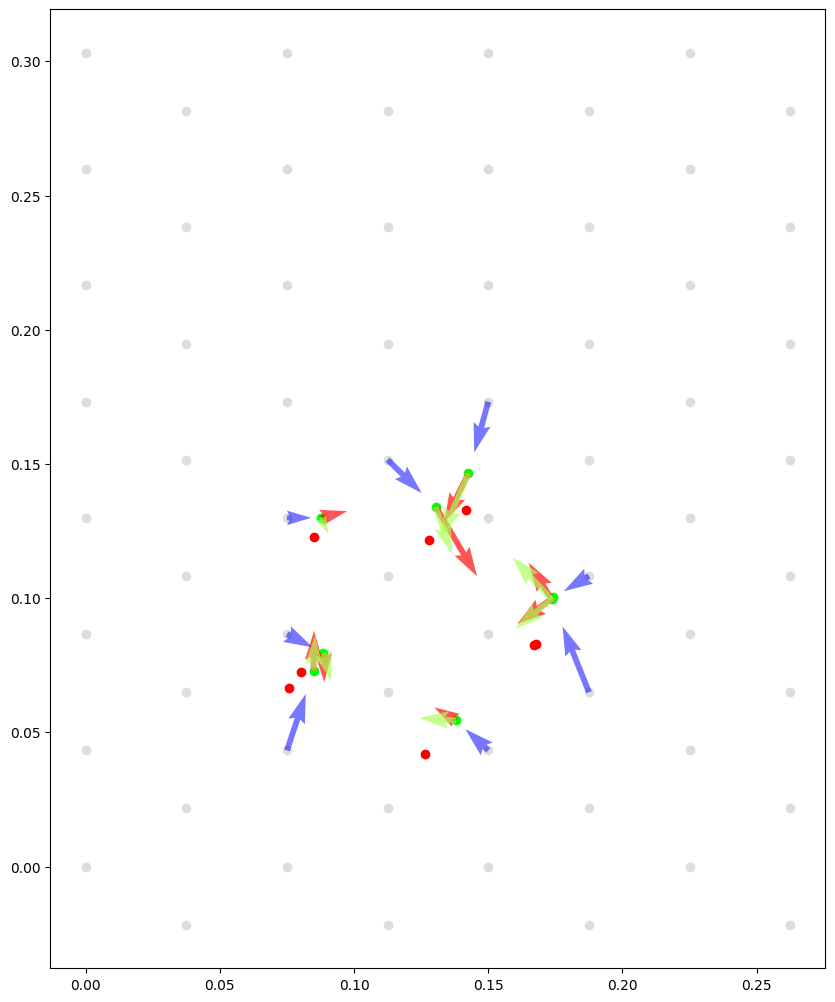

[[ 0.0311  0.0171]
 [ 0.0254 -0.0358]
 [-0.0036 -0.0024]
 [-0.0007 -0.0214]
 [-0.0043  0.0168]
 [-0.0095 -0.0417]
 [-0.0201 -0.0067]
 [-0.0201 -0.034 ]]


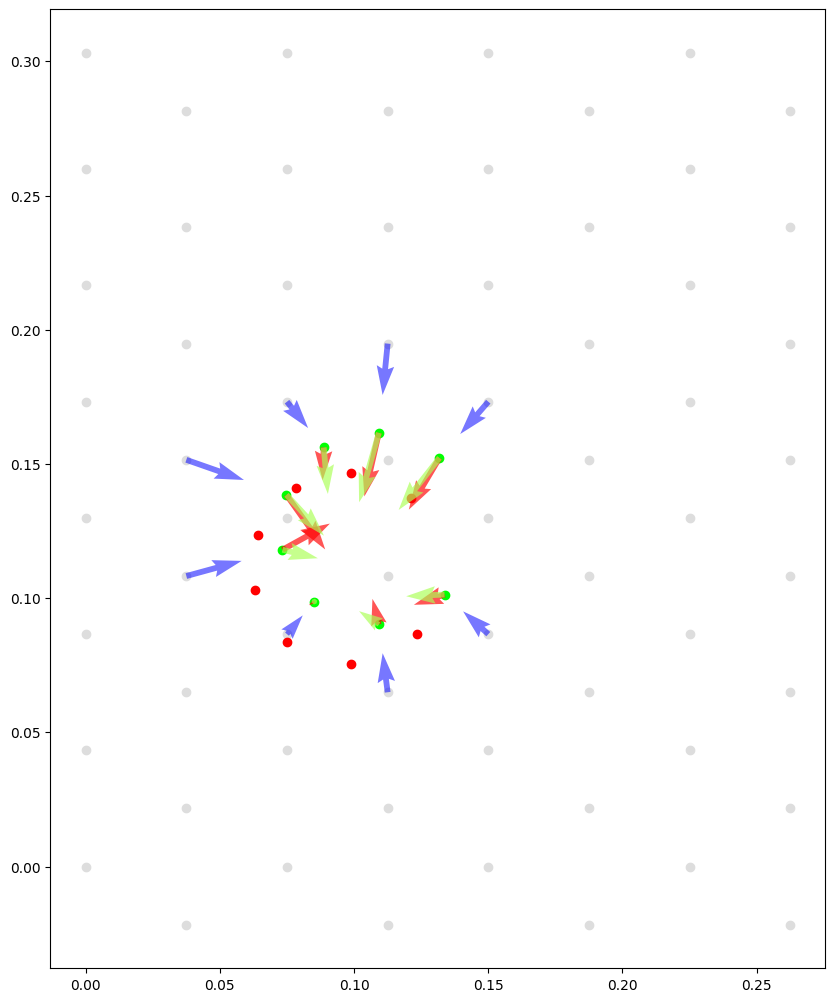

[[ 2.5789e-02 -3.8730e-05]
 [-3.3206e-03  1.3835e-02]
 [ 3.6772e-03 -9.2922e-03]
 [-6.2927e-02  7.3303e-03]
 [-1.2398e-02 -5.1956e-03]]


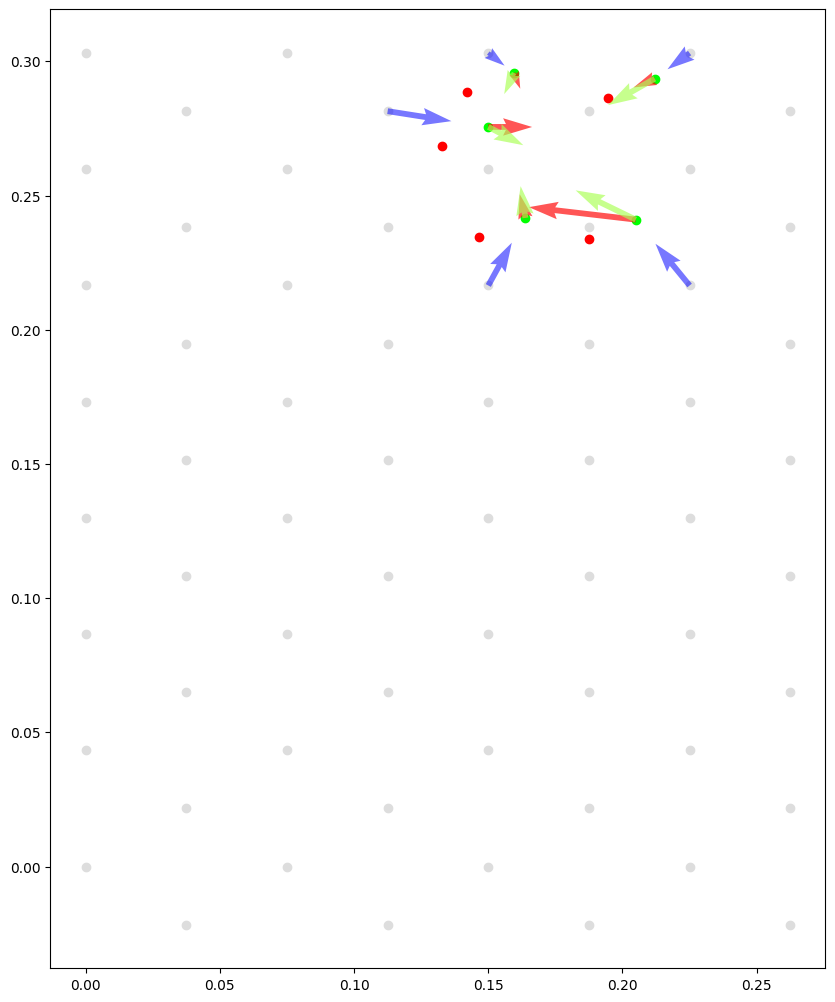

[[ 0.0162  0.0046]
 [ 0.0103 -0.0133]
 [-0.0228  0.0238]
 [ 0.0058 -0.0524]
 [-0.0367  0.0072]]


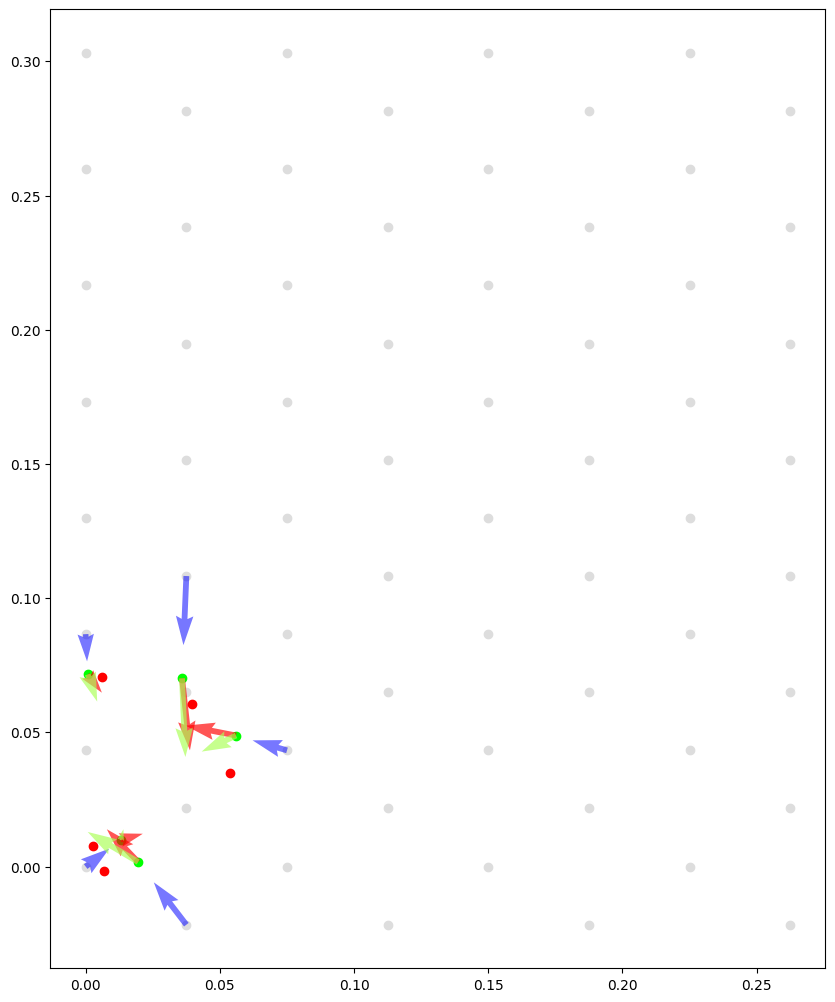

[[ 0.031   0.0176]
 [ 0.0607 -0.0031]
 [ 0.0163  0.031 ]
 [ 0.0205  0.004 ]
 [ 0.0089  0.0527]
 [-0.0309  0.0282]
 [-0.0173  0.0155]
 [-0.0156 -0.0089]]


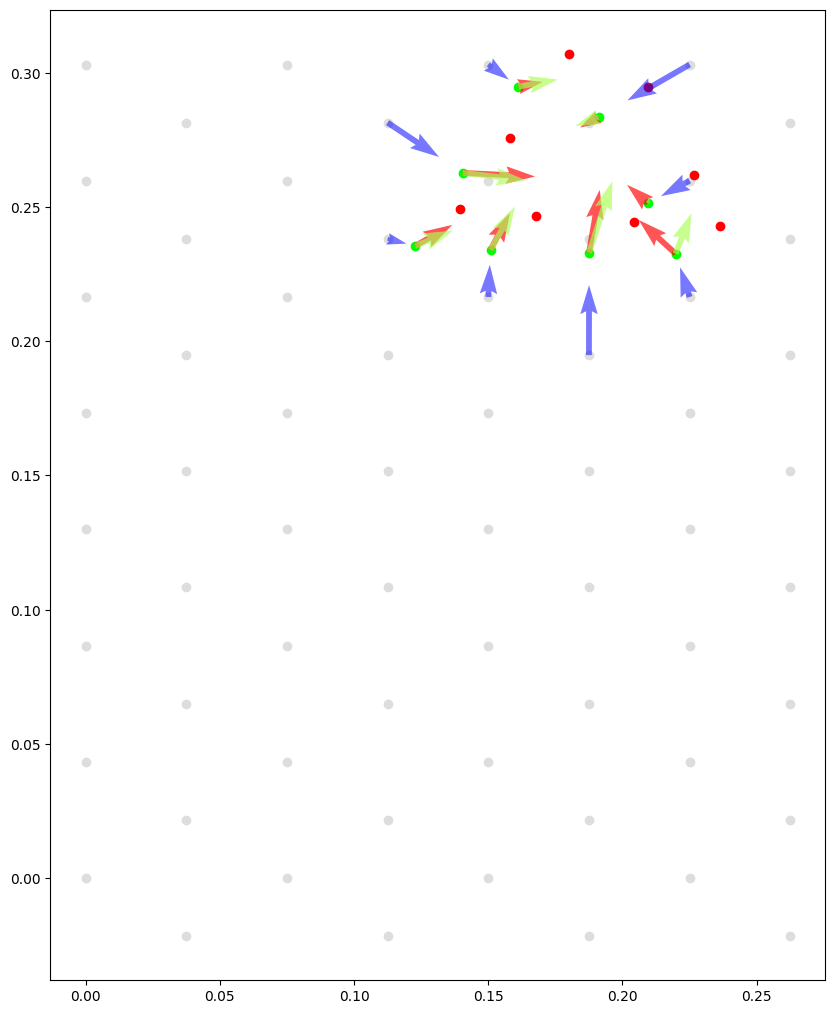

[[ 0.0311  0.0136]
 [ 0.0276  0.0461]
 [ 0.0015 -0.0019]
 [ 0.0011 -0.0211]
 [-0.033   0.0257]
 [-0.013   0.0114]]


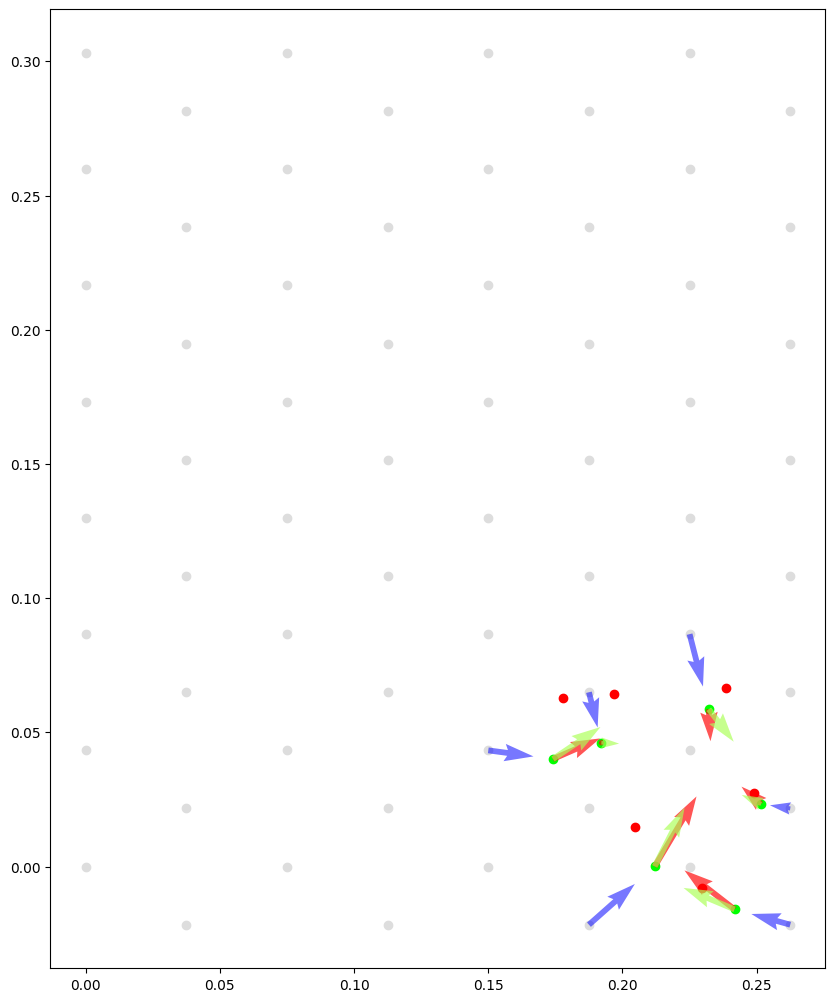

[[ 0.0363  0.0046]
 [ 0.0247  0.0016]
 [ 0.0347 -0.0128]
 [-0.0036  0.0038]
 [-0.0182  0.0284]
 [-0.0051 -0.0257]
 [-0.0167  0.0208]
 [-0.025  -0.0112]
 [-0.0162 -0.0144]]


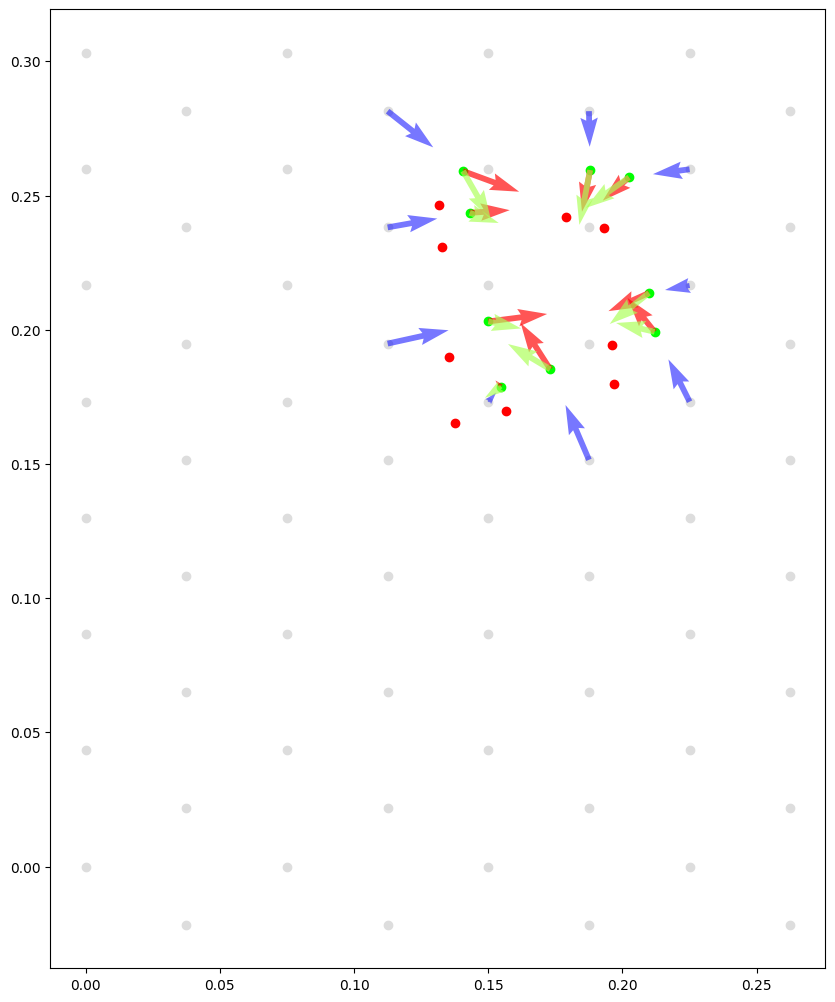

[[ 0.0272 -0.0048]
 [ 0.0176  0.0076]
 [ 0.0285 -0.0041]
 [ 0.0427 -0.0083]
 [-0.0169  0.0257]
 [-0.0229  0.022 ]
 [-0.0087 -0.0182]
 [-0.0049 -0.015 ]]


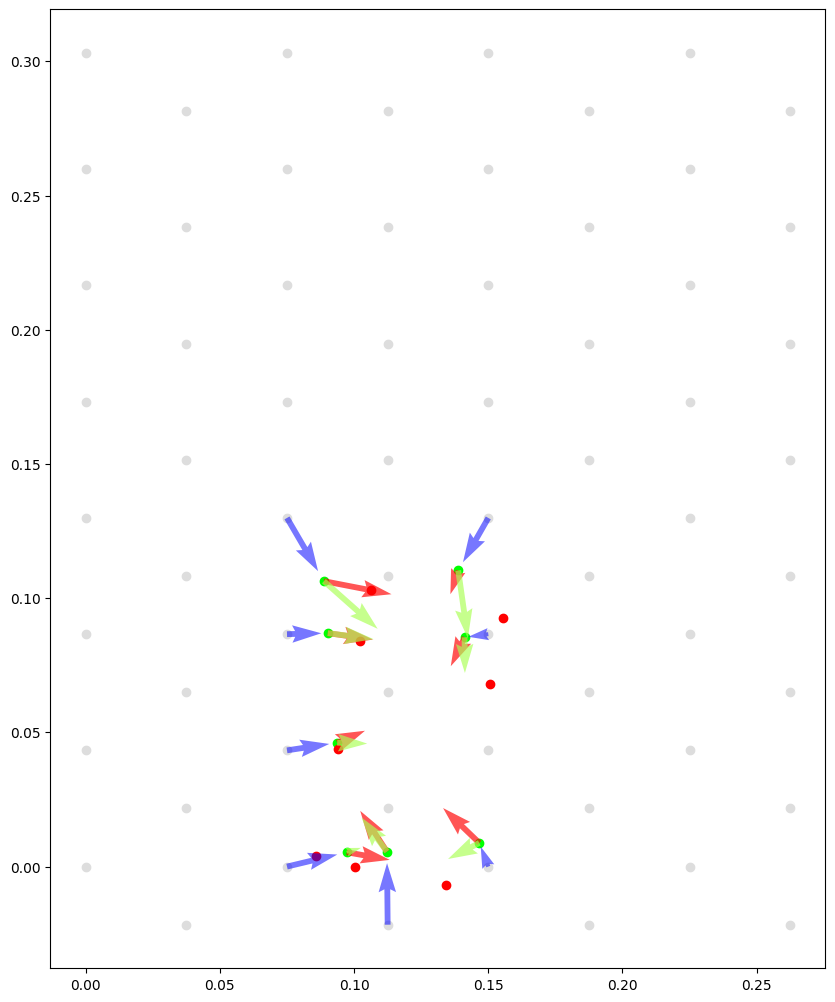

[[ 0.0435  0.0192]
 [ 0.0321  0.0019]
 [ 0.0487 -0.0132]
 [ 0.0143  0.0352]
 [ 0.0074 -0.0317]
 [ 0.0046  0.0129]
 [-0.0014 -0.0079]
 [-0.0267  0.0152]
 [-0.0279 -0.0115]]


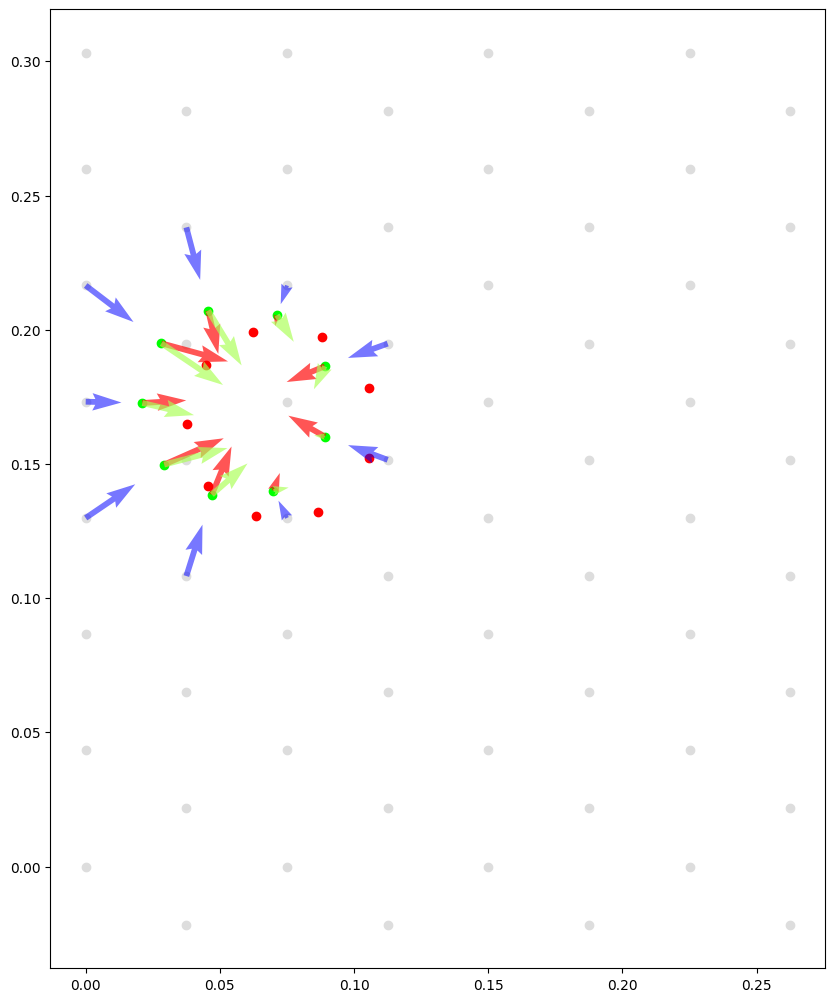

In [36]:
losses = []
for n, (state, action, action_gt, pos) in enumerate(zip(statesss, actionsss, actions_gt, possss)):
    state, action, action_gt, pos = state, action, action_gt, pos
    pos = pos.detach().cpu().numpy()
    acts = action.detach().cpu().numpy()
    acts_gt = action_gt.detach().cpu().numpy()
    state = state.detach().cpu().numpy()


    # state = state_scaler.inverse_transform(state)
    # acts = action_scaler.inverse_transform(acts)
    # acts_gt = action_scaler.inverse_transform(act_gt)

    for n, idx in enumerate(range(state.shape[0])):
    # idx = 0
        po = pos[idx]
        n_agents = len([p for p in po if p != 0])
        r_poses = kdtree_positions_world[po[:n_agents]]
        init_pts = state[idx][:n_agents,:2] + r_poses
        goal_bd_pts = state[idx][:n_agents,2:4] + r_poses
        act_grsp = state[idx][:n_agents,4:6]
        act = acts[idx, :n_agents]
        print(act)
        act_gt = acts_gt[idx, :n_agents]
        r_poses2 = r_poses + act_grsp

        losses.append(np.linalg.norm(act - act_gt))
        # acts = acts/np.linalg.norm(acts, axis=1).reshape(-1, 1)
        # act_gt = act_gt/np.linalg.norm(act_gt, axis=1).reshape(-1, 1)



        plt.figure(figsize=(10,17.78))
        plt.scatter(kdtree_positions_world[:, 0], kdtree_positions_world[:, 1], c='#ddddddff')
        plt.scatter(init_pts[:, 0], init_pts[:, 1], c = '#00ff00ff')
        plt.scatter(goal_bd_pts[:, 0], goal_bd_pts[:, 1], c='red')

        plt.quiver(r_poses[:, 0], r_poses[:, 1], act_grsp[:, 0], act_grsp[:, 1], color='#0000ff88')
        plt.quiver(r_poses2[:, 0], r_poses2[:, 1], act[:, 0], act[:, 1], color='#ff0000aa')
        plt.quiver(r_poses2[:, 0], r_poses2[:, 1], act_gt[:, 0], act_gt[:, 1], color='#aaff55aa')

        plt.gca().set_aspect('equal')
        plt.show()

        if n%50 == 0:
            break

In [ ]:
import numpy as np
import plotly.graph_objs as go
import plotly.figure_factory as ff

# Dummy function to simulate pretrained diffusion model
def diffusion_model(state):
    # Generates dummy actions conditioned on state
    return np.sin(state) + np.random.normal(scale=0.1, size=state.shape)

# Dummy function to compute the score function for the actions
def compute_score_function(actions):
    # Compute a dummy score function for visualization
    return np.gradient(actions, axis=0)

# Example data
num_samples = 100
state_dim = 3  # Example state dimension
states = np.linspace(-10, 10, num_samples).reshape(-1, 1) * np.ones((1, state_dim))

# Generate actions using the pretrained diffusion model
actions = diffusion_model(states)

# Compute the score function for the actions
score_function = compute_score_function(actions)

# Create a 3D plot of the score function
fig = go.Figure()

for i in range(state_dim):
    # Add traces for each dimension of the score function
    fig.add_trace(go.Scatter3d(
        x=states[:, 0],
        y=actions[:, i],
        z=score_function[:, i],
        mode='lines',
        name=f'Score Dimension {i+1}',
        line=dict(width=4)
    ))

# Customize the layout for better presentation
fig.update_layout(
    title='3D Visualization of the Score Function',
    scene=dict(
        xaxis_title='State',
        yaxis_title='Action',
        zaxis_title='Score'
    ),
    legend=dict(x=0.1, y=0.9)
)

# Show the plot
fig.show()


In [ ]:
# BYOL for learning robot idx embeddings
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class IntegerEmbeddingModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(IntegerEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, x):
        return self.embedding(x)

def contrastive_loss(embedding1, embedding2):
    # Simple contrastive loss that encourages the model to make embeddings similar
    # You might want to experiment with more sophisticated losses
    return ((embedding1 - embedding2)**2).mean()

# Model parameters
num_embeddings = 64  # For integers 0-63
embedding_dim = 128  # Size of the embedding vector
batch_size = 64

# Model, optimizer, and loss function
model = IntegerEmbeddingModel(num_embeddings, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-6)

# Training loop
num_epochs = 10000
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Generate a batch of integer indices
    # In a real scenario, you might want to sample these more carefully
    indices = torch.randint(0, num_embeddings, (batch_size,))  # Batch size of 32

    # "View 1" is just the embedding
    embedding1 = model(indices)

    # "View 2" could be the embedding of the next integer, simulating a simple 'transformation'
    # This is a simplistic approach; consider more sophisticated methods for your task
    indices_2 = (indices + torch.randint(0, num_embeddings, (batch_size,))) % num_embeddings  # Ensure it wraps around at the max integer
    embedding2 = model(indices_2)

    # Compute the loss and update the model
    # loss = contrastive_loss(embedding1, embedding2)
    loss = triplet_loss(embedding1, embedding1, embedding2)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
n_values = torch.arange(64)
a = model(n_values)
b = model(n_values)
cos_sim = torch.nn.CosineSimilarity(dim=0)

cos_sim_matrix = torch.zeros(64, 64)

for i in range(64):
    for j in range(64):
        cos_sim_matrix[i, j] = cos_sim(a[i], b[j])


# Plotting the heatmap
plt.figure(figsize=(8, 6))
plt.title("Heatmap of Cosine Similarity")
plt.imshow(cos_sim_matrix.detach().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
a = torch.randint(0, 64, (32,10))
op = model(a)
op.shape

In [ ]:
class ShapeEmbeddingModel(nn.Module):
    def __init__(self, num_bd_pts, hidden_dim, embed_dim):
        super(ShapeEmbeddingModel, self).__init__()
        self.layer1 = nn.Linear(num_bd_pts, hidden_dim)
        self.layer2 = nn.Linear(num_bd_pts, hidden_dim)
        self.layer3 = nn.Linear(num_bd_pts, embed_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

def contrastive_loss(embedding1, embedding2):
    # Simple contrastive loss that encourages the model to make embeddings similar
    # You might want to experiment with more sophisticated losses
    return ((embedding1 - embedding2)**2).mean()

# def triplet_loss(anchor, positive, negative, margin=1.0):
#     distance_positive = torch.nn.functional.pairwise_distance(anchor, positive, keepdim=True)
#     distance_negative = torch.nn.functional.pairwise_distance(anchor, negative, keepdim=True)
#     losses = torch.relu(distance_positive - distance_negative + margin)
#     return losses.mean()


bd_pts_dict = pkl.load(open('../../config/assets/obj_props.pkl', 'rb'))
bd_pts = []
for name in bd_pts_dict.keys():
    bd_pts.append(bd_pts_dict[name][1].reshape(512,))

bd_pts = torch.tensor(bd_pts).float()

In [ ]:
# Model parameters
num_objects = 9
num_bd_pts = 256*2  # For integers 0-63
embedding_dim = 128  # Size of the embedding vector
batch_size = 64

# Model, optimizer, and loss function
model = ShapeEmbeddingModel(num_bd_pts, 512, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-6)

# Training loop
num_epochs = 10000
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()

    indices = torch.randint(0, num_objects, (batch_size,))
    input1 = torch.index_select(data, 0, indices)
    embedding1 = model(input1)

    indices_2 = (indices + torch.randint(0, num_objects, (batch_size,))) % num_objects  # Ensure it wraps around at the max integer
    input2 = torch.index_select(data, 0, indices_2)
    embedding2 = model(input2)

    # Compute the loss and update the model
    # loss = contrastive_loss(embedding1, embedding2)
    loss = triplet_loss(embedding1, embedding1, embedding2)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
